# Imports

In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
!pip install pmdarima
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
!pip install geopy
from geopy.geocoders import Nominatim
!pip install networkx
import networkx as nx
import requests
import math
import random
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.5 MB/s eta 0:00:00


# Mounting GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/BDM_CAPSTONE_PROJECT/

/content/drive/MyDrive/BDM_CAPSTONE_PROJECT


# Load Data

In [4]:
df = pd.read_csv('DATA/preprocessed_data.csv')

In [5]:
df.sample(10)

,DATE,DEMAND,FROM,TO,DISTANCE,PROFIT,LAGAN,FUEL_COST_PER_LITRE,TMIN,TMAX,PRCP
66,2024-04-15,1.0,Masaurhi,Unknown,51.00000,1000.000000,0.0,92.03,27.4,40.0,0.0
104,2024-02-20,1.0,Masaurhi,Nawada,140.00000,2500.000000,0.0,94.02,15.2,30.0,0.0
84,2024-03-14,1.0,Masaurhi,Unknown,87.80000,1000.000000,0.0,94.02,20.0,34.0,0.0
253,2023-02-28,1.0,Masaurhi,Unknown,61.80000,1500.000000,1.0,94.02,17.2,32.0,0.0
170,2023-10-10,1.0,Masaurhi,Siwan,54.80000,1200.000000,0.0,94.02,26.4,35.4,0.0
126,2024-01-19,1.0,Masaurhi,Unknown,30.00000,1800.000000,0.0,94.02,10.0,18.2,0.0
285,2023-01-17,1.0,Masaurhi,Unknown,80.85748,1518.818898,0.0,94.02,6.4,20.0,0.0
264,2023-02-14,1.0,Masaurhi,Unknown,80.85748,1518.818898,1.0,94.02,11.0,25.0,0.0
240,2023-04-14,1.0,Masaurhi,Unknown,87.60000,1400.000000,0.0,94.02,24.6,41.0,0.0
165,2023-11-14,1.0,Masaurhi,Unknown,77.00000,2000.000000,0.0,94.02,17.2,31.0,0.0


# Feature Engineering


$$
\text{Fuel Cost} = \left( \frac{\text{Distance}}{\text{Mileage}} \right) \times \text{Fuel Cost per Litre}
$$


In [6]:
mileage = 15
df['FUEL_COST'] = df['DISTANCE'] / mileage * df['FUEL_COST_PER_LITRE']


$$
\text{Efficiency} = \frac{\text{Profit}}{\text{Fuel Cost}}
$$

In [7]:
df['EFFICIENCY'] = df['PROFIT'] / df['FUEL_COST']

In [8]:
df.drop('FUEL_COST_PER_LITRE', axis=1, inplace=True)

In [9]:
df.describe()

,DEMAND,DISTANCE,PROFIT,LAGAN,TMIN,TMAX,PRCP,FUEL_COST,EFFICIENCY
count,350.0,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,1.0,80.857480,1518.818898,0.285714,20.768857,31.775143,1.967714,504.003063,3.437740
std,0.0,28.647207,480.932850,0.452401,7.016565,6.827824,6.145254,176.801290,2.013355
min,1.0,20.000000,800.000000,0.000000,6.400000,13.000000,0.000000,125.360000,0.958767
25%,1.0,61.800000,1200.000000,0.000000,14.650000,27.000000,0.000000,387.362400,2.469550
50%,1.0,80.857480,1500.000000,0.000000,20.850000,32.000000,0.000000,506.814687,2.996793
75%,1.0,87.800000,1518.818898,1.000000,27.200000,37.000000,0.000000,549.076800,3.872343
max,1.0,223.000000,3800.000000,1.000000,32.800000,44.000000,42.900000,1368.179333,18.827764


In [10]:
df['DATE'] = pd.to_datetime(df['DATE'])

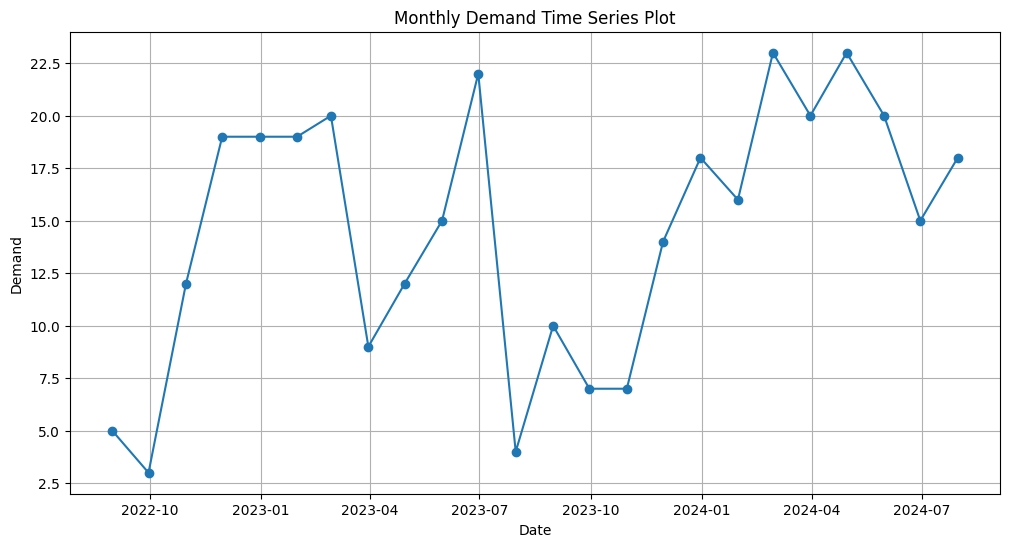

In [11]:
monthly_demand = df.copy()
monthly_demand.set_index('DATE', inplace=True)
monthly_demand = monthly_demand['DEMAND'].resample('M').sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_demand, marker='o')
plt.title('Monthly Demand Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.grid(True)
# plt.savefig('CHARTS/monthly_demand_plot.png')
plt.show()

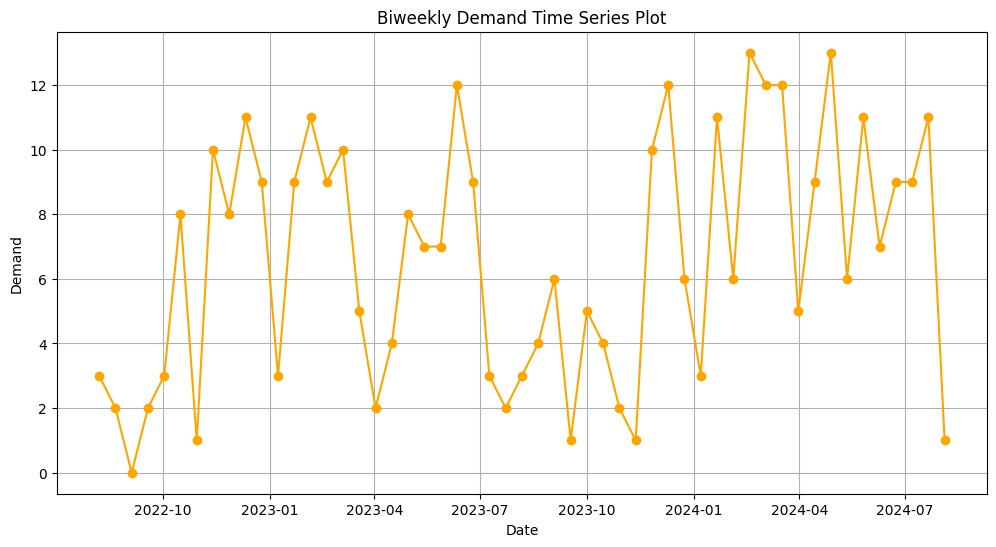

In [12]:
biweekly_demand = df.copy()
biweekly_demand.set_index('DATE', inplace=True)
biweekly_demand = biweekly_demand['DEMAND'].resample('2W').sum()

plt.figure(figsize=(12, 6))
plt.plot(biweekly_demand, marker='o', color='orange')
plt.title('Biweekly Demand Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.grid(True)
# plt.savefig('CHARTS/biweekly_demand_plot.png')
plt.show()

In [13]:
location_df = pd.read_csv('DATA/location.csv')

In [14]:
location_df.head()

,LOCATION,LATITUDE,LONGITUDE
0,Punpun,25.463909,85.112189
1,Fatehpur,24.608398,85.226437
2,Hilsa,25.300683,85.249383
3,Hazipur,24.949065,85.614829
4,Koilwar,25.580120,84.757256


In [15]:
df.FROM.value_counts()

,count
FROM,
Masaurhi,334
Sarwan,5
Nadwan,4
Patna,2
Daulatpur,2
Jehanabad,1
Diara Malahi,1
Imaliya,1


In [16]:
334/sum([334, 5, 4, 2, 2, 1, 1, 1])

0.9542857142857143

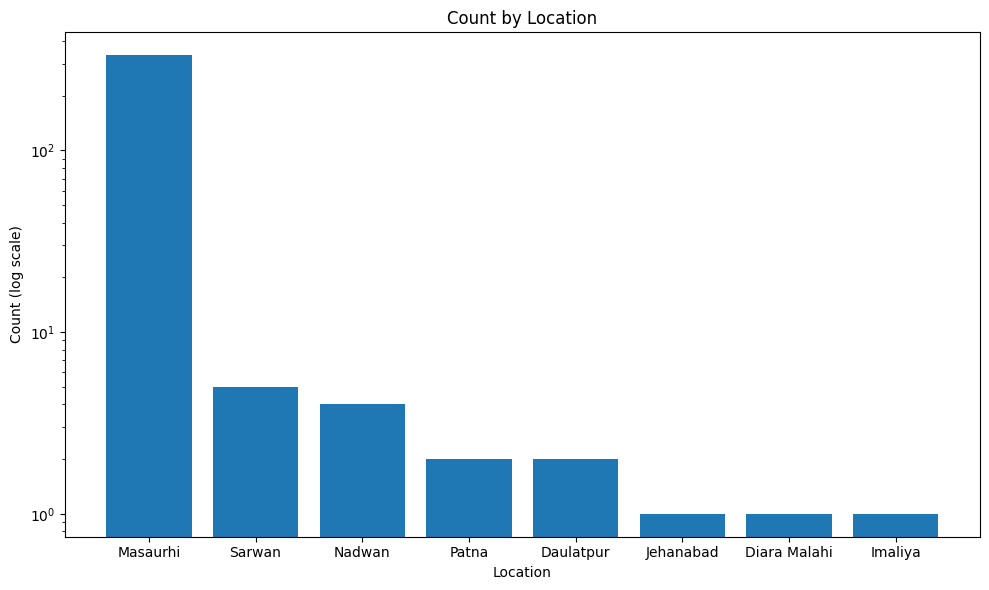

In [17]:
data = {
    'Location': ['Masaurhi', 'Sarwan', 'Nadwan', 'Patna', 'Daulatpur', 'Jehanabad', 'Diara Malahi', 'Imaliya'],
    'Count': [334, 5, 4, 2, 2, 1, 1, 1]
}
location_df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.bar(location_df['Location'], location_df['Count'])
plt.yscale('log')
plt.xlabel('Location')
plt.ylabel('Count (log scale)')
plt.title('Count by Location')
plt.tight_layout()
plt.show()

In [18]:
location_df = pd.read_csv('DATA/location.csv')
location_df.head()

,LOCATION,LATITUDE,LONGITUDE
0,Punpun,25.463909,85.112189
1,Fatehpur,24.608398,85.226437
2,Hilsa,25.300683,85.249383
3,Hazipur,24.949065,85.614829
4,Koilwar,25.580120,84.757256


In [19]:
location_counts = df['TO'].value_counts().reset_index()
location_counts.columns = ['LOCATION', 'COUNT']

In [20]:
merged_df = pd.merge(location_counts, location_df, on='LOCATION')

total_count = merged_df['COUNT'].sum()
merged_df['PERCENTAGE'] = (merged_df['COUNT'] / total_count) * 100

m = folium.Map(location=[merged_df['LATITUDE'].mean(), merged_df['LONGITUDE'].mean()], zoom_start=8)

for _, row in merged_df.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=f"{row['LOCATION']}: {row['PERCENTAGE']:.2f}%",
        tooltip=row['LOCATION']
    ).add_to(m)

# m.save("SUPPLEMENTS/map.html")
m

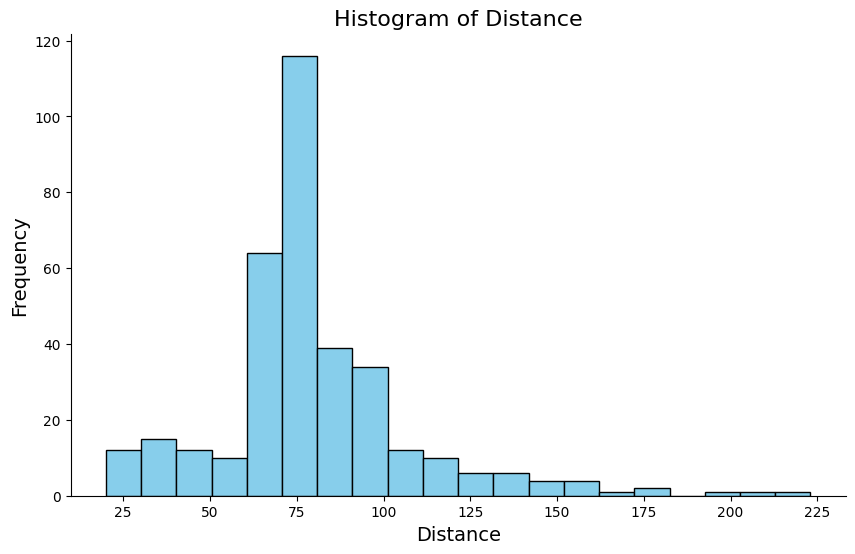

In [21]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
df['DISTANCE'].plot(kind='hist', bins=20, title='Distance', color='skyblue', edgecolor='black')

# Customize plot appearance
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of Distance', fontsize=16)

# Save the plot in high quality
# plt.savefig('distance_histogram.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

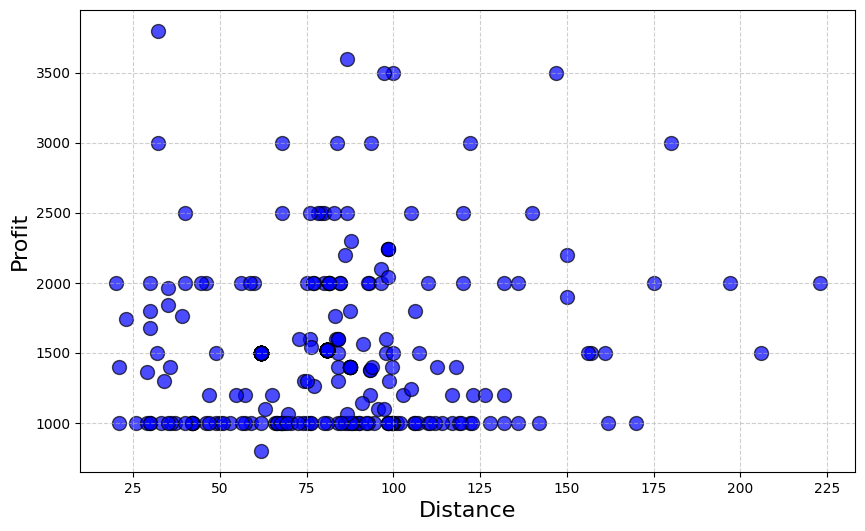

In [22]:

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['DISTANCE'], df['PROFIT'], color='blue', edgecolor='k', alpha=0.7, s=100)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and title with custom fonts and sizes
plt.xlabel('Distance', fontsize=16)
plt.ylabel('Profit', fontsize=16)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the plot
# plt.savefig('CHARTS/distance_vs_profit.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

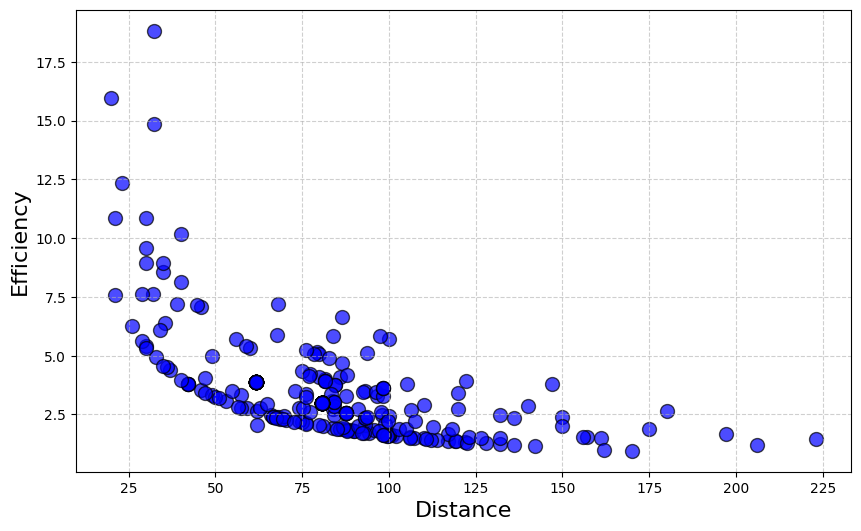

In [23]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['DISTANCE'], df['EFFICIENCY'], color='blue', edgecolor='k', alpha=0.7, s=100)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and title with custom fonts and sizes
plt.xlabel('Distance', fontsize=16)
plt.ylabel('Efficiency', fontsize=16)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the plot
# plt.savefig('CHARTS/distance_vs_efficiency.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

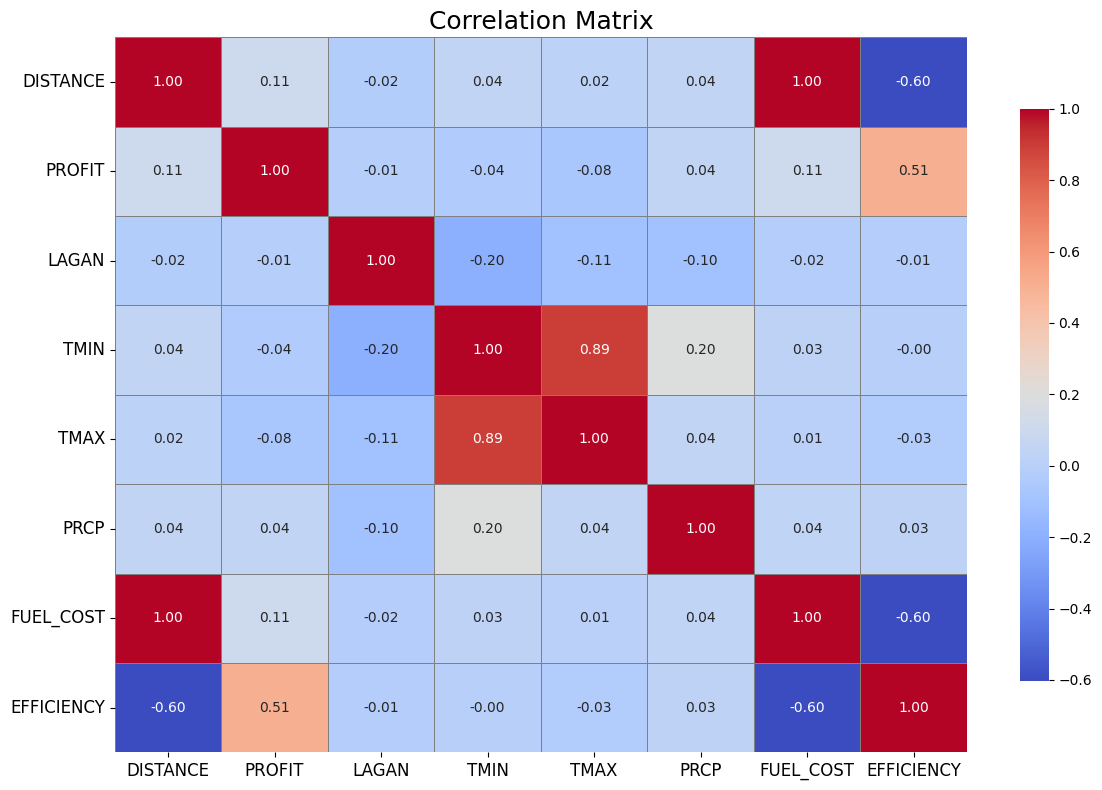

In [24]:
# Compute the correlation matrix
corr = df.drop('DEMAND', axis=1).corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'shrink': .8}, linewidths=0.5, linecolor='gray')

# Add title and labels
plt.title('Correlation Matrix', fontsize=18)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)

# Adjust layout to make room for the labels
plt.tight_layout()

# Save the heatmap
# plt.savefig('CHARTS/correlation_heatmap.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

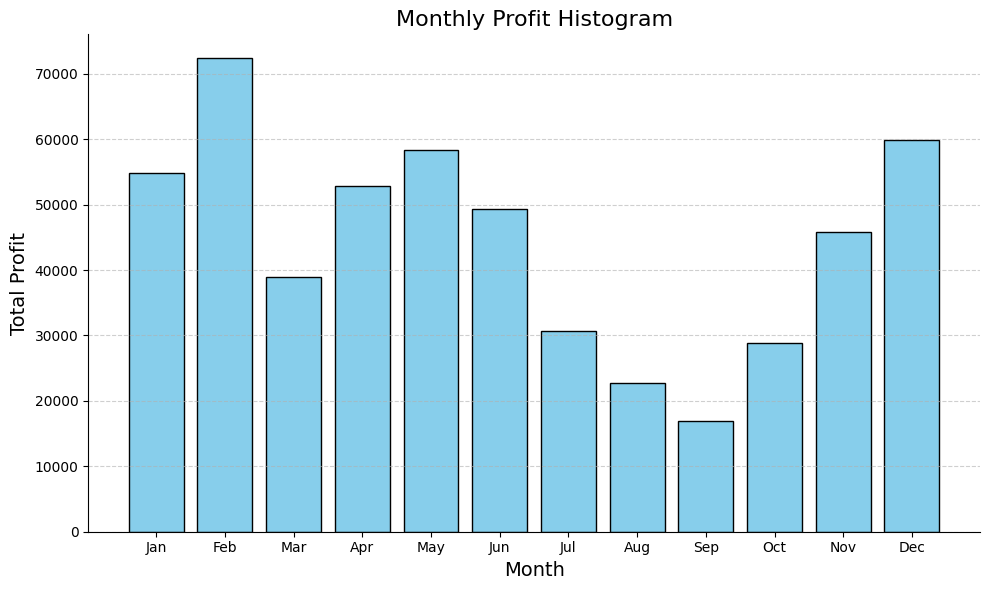

In [25]:
# Make a copy of the DataFrame and extract the month
month_df = df.copy()
month_df['MONTH'] = month_df['DATE'].dt.month

# Group the data by month and calculate the total profit for each month
monthly_profit = month_df.groupby('MONTH')['PROFIT'].sum()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_profit.index, monthly_profit.values, color='skyblue', edgecolor='black')

# Customize the plot
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Profit', fontsize=14)
plt.title('Monthly Profit Histogram', fontsize=16)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Save the plot
plt.tight_layout()
# plt.savefig('CHARTS/monthly_profit_histogram.png', format='png', dpi=300)

# Show the plot
plt.show()

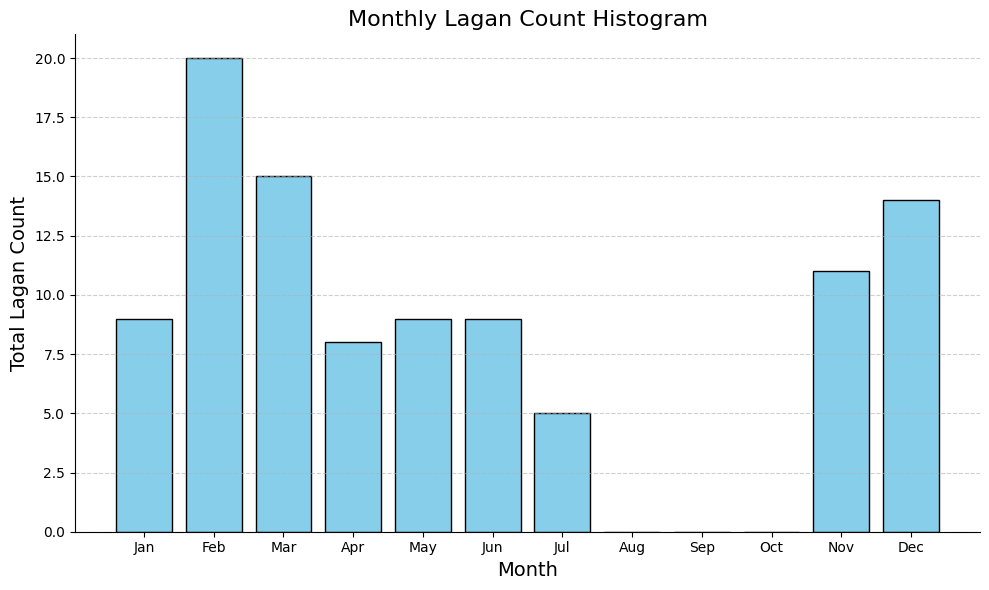

In [26]:
month_df = df.copy()
month_df['MONTH'] = month_df['DATE'].dt.month

# Group the data by month and calculate the total lagan count for each month
monthly_lagan_count = month_df.groupby('MONTH')['LAGAN'].sum()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_lagan_count.index, monthly_lagan_count.values, color='skyblue', edgecolor='black')

# Customize the plot
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Lagan Count', fontsize=14)
plt.title('Monthly Lagan Count Histogram', fontsize=16)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Save the plot
plt.tight_layout()
# plt.savefig('CHARTS/monthly_lagan_count_histogram.png', format='png', dpi=300)

# Show the plot
plt.show()

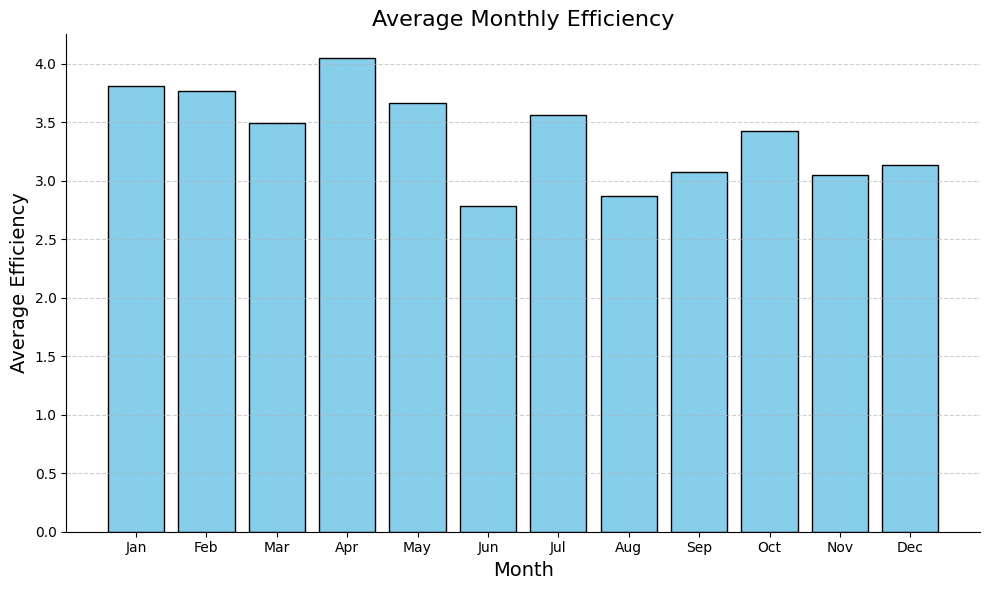

In [27]:
monthly_efficiency = month_df.groupby('MONTH')['EFFICIENCY'].mean()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(monthly_efficiency.index, monthly_efficiency.values, color='skyblue', edgecolor='black')

# Customize the plot
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Efficiency', fontsize=14)
plt.title('Average Monthly Efficiency', fontsize=16)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Save the plot
plt.tight_layout()
# plt.savefig('CHARTS/average_monthly_efficiency.png', format='png', dpi=300)

# Show the plot
plt.show()

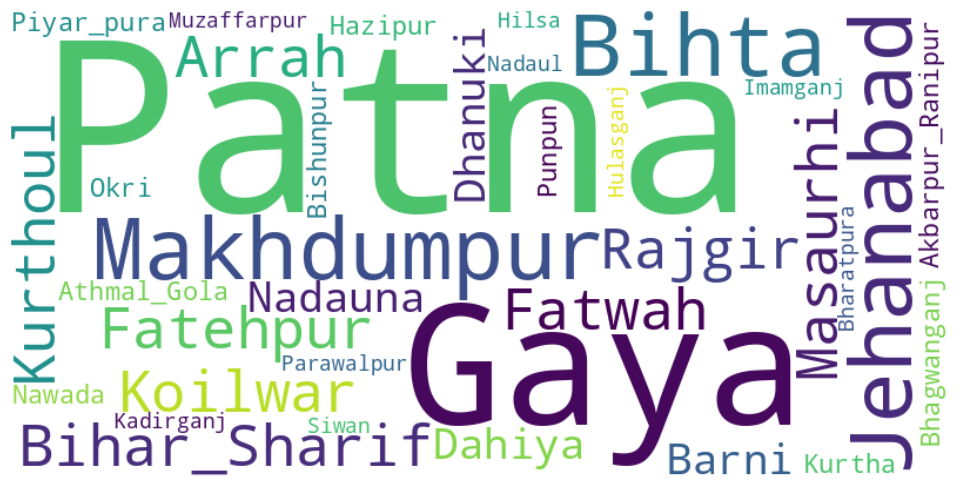

In [28]:
processed_to = ['_'.join(x.split()) for x in df.TO.tolist() if x != 'Unknown']
text = ' '.join(processed_to)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Save the word cloud as an image
plt.tight_layout()
# plt.savefig('CHARTS/word_cloud.png', format='png', dpi=300)

# Show the plot
plt.show()

In [29]:
df

,DATE,DEMAND,FROM,TO,DISTANCE,PROFIT,LAGAN,TMIN,TMAX,PRCP,FUEL_COST,EFFICIENCY
0,2024-07-22,1.0,Masaurhi,Unknown,132.00000,1000.000000,0.0,31.0,36.0,0.6,809.864000,1.234775
1,2024-07-21,1.0,Masaurhi,Unknown,46.00000,1000.000000,0.0,31.0,35.0,0.4,282.225333,3.543268
2,2024-07-17,1.0,Masaurhi,Unknown,122.00000,1000.000000,0.0,29.2,37.0,0.0,748.510667,1.335986
3,2024-07-16,1.0,Masaurhi,Unknown,59.00000,1000.000000,0.0,29.6,35.0,0.0,361.984667,2.762548
4,2024-07-15,1.0,Masaurhi,Unknown,83.80000,3000.000000,1.0,28.8,37.0,5.1,514.140933,5.834976
...,...,...,...,...,...,...,...,...,...,...,...,...
345,2022-08-19,1.0,Masaurhi,Unknown,80.85748,1518.818898,0.0,25.4,34.4,0.0,506.814687,2.996793
346,2022-08-09,1.0,Masaurhi,Unknown,80.85748,1518.818898,0.0,28.0,33.4,0.0,506.814687,2.996793
347,2022-08-07,1.0,Masaurhi,Unknown,80.85748,1518.818898,0.0,28.0,34.0,17.2,506.814687,2.996793
348,2022-08-06,1.0,Masaurhi,Unknown,80.85748,1518.818898,0.0,28.0,35.0,5.9,506.814687,2.996793


# Time Series Analysis

In [30]:
# Ensure DATE column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Set DATE as the index
df.set_index('DATE', inplace=True)

monthly_demand = df['DEMAND'].resample('M').sum()

## SARIMAX Model

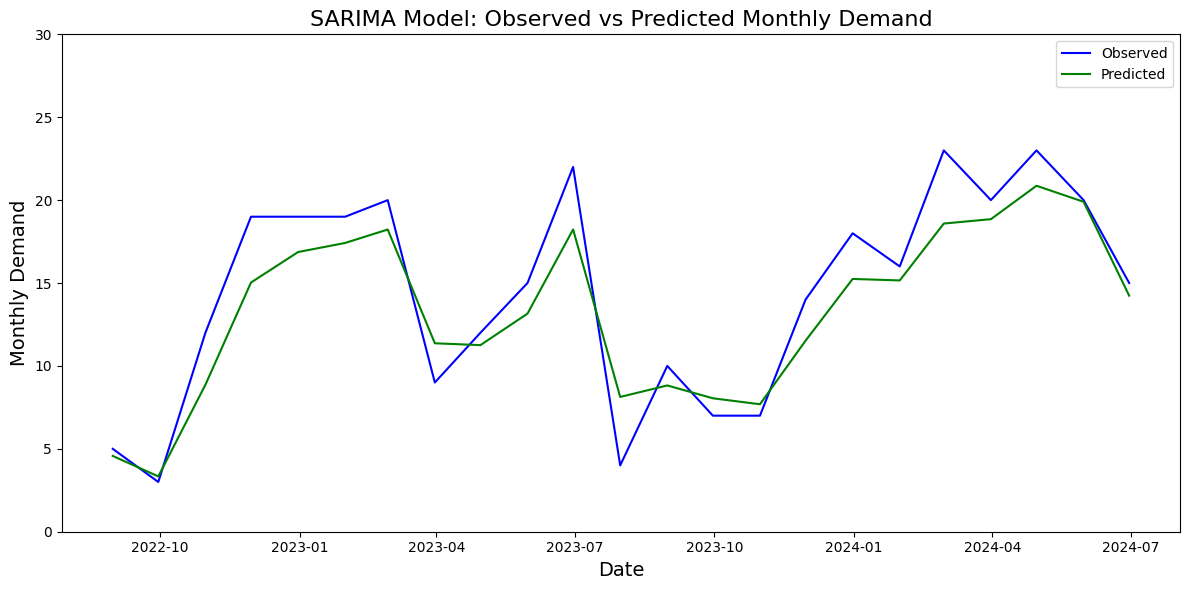

In [31]:
# Define the SARIMA model
model = SARIMAX(monthly_demand, order=(1, 0, 1), seasonal_order=(1, 0, 2, 12))

# Fit the model
results = model.fit()

# Generate predictions
pred = results.get_prediction(start=monthly_demand.index[0], end=monthly_demand.index[-1])

# Plot the observed and predicted values
plt.figure(figsize=(12, 6))
plt.plot(monthly_demand.index[:-1], monthly_demand[:-1], label='Observed', color='blue')
plt.plot(pred.predicted_mean.index[:-1], pred.predicted_mean[1:], label='Predicted', color='green')

# Customize the plot
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Demand', fontsize=14)
plt.ylim(0, 30)
plt.title('SARIMA Model: Observed vs Predicted Monthly Demand', fontsize=16)
plt.legend()

# Save the plot
plt.tight_layout()
# plt.savefig('CHARTS/sarima_observed_vs_predicted.png', format='png', dpi=300)

# Show the plot
plt.show()

In [32]:
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                  DEMAND   No. Observations:                   24
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 -77.108
Date:                                 Thu, 15 Aug 2024   AIC                            166.217
Time:                                         12:36:58   BIC                            173.285
Sample:                                     08-31-2022   HQIC                           168.092
                                          - 07-31-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9481      0.087     10.913      0.000       0.778       1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


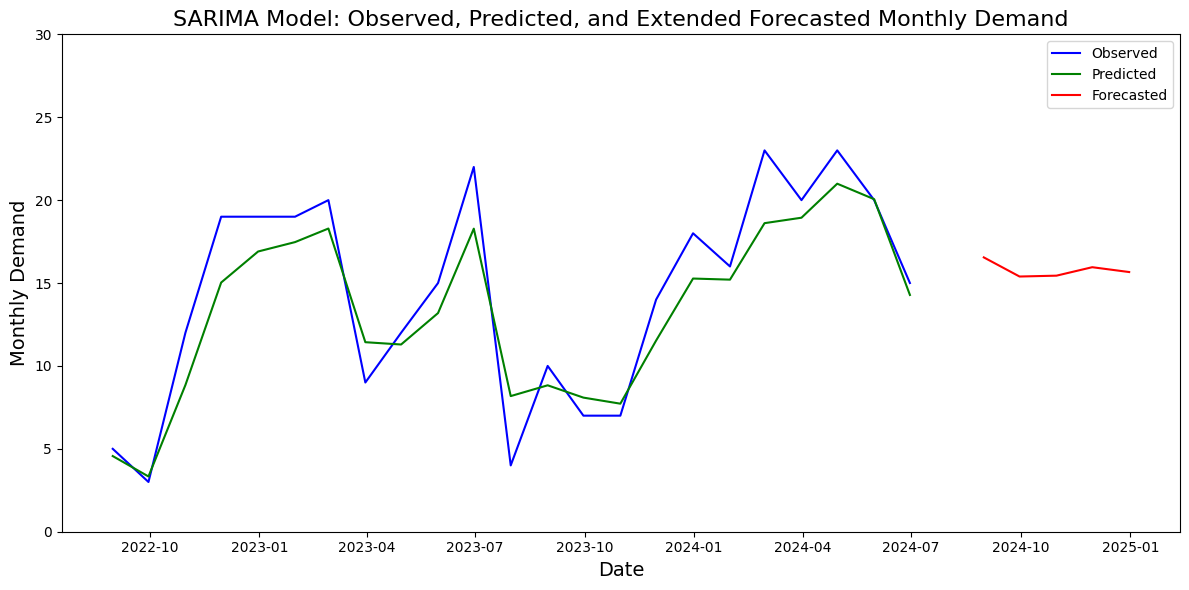

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd

# Define the SARIMA model
model = SARIMAX(monthly_demand, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))

# Fit the model
results = model.fit()

# Generate predictions
pred = results.get_prediction(start=monthly_demand.index[0], end=monthly_demand.index[-1])

# Generate forecasts for the next 5 months
forecast = results.get_forecast(steps=6)

# Extend the forecast to include one previous month and year
extended_index = pd.date_range(start=monthly_demand.index[-1], periods=6, freq='M')
extended_forecast = pd.Series(forecast.predicted_mean, index=extended_index)

# Plot the observed, predicted, and extended forecasted values
plt.figure(figsize=(12, 6))
plt.plot(monthly_demand.index[:-1], monthly_demand[:-1], label='Observed', color='blue')
plt.plot(pred.predicted_mean.index[:-1], pred.predicted_mean[1:], label='Predicted', color='green')
plt.plot(extended_forecast.index, extended_forecast, label='Forecasted', color='red')

# Customize the plot
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Demand', fontsize=14)
plt.ylim(0, 30)
plt.title('SARIMA Model: Observed, Predicted, and Extended Forecasted Monthly Demand', fontsize=16)
plt.legend()

# Save the plot
plt.tight_layout()
# plt.savefig('CHARTS/sarima_observed_vs_predicted_forecast_extended.png', format='png', dpi=300)

# Show the plot
plt.show()


In [34]:
# prompt: calculate r2 score between monthly_demand and pred = results.get_prediction(start=monthly_demand.index[0], end=monthly_demand.index[-1])

from sklearn.metrics import r2_score

# Extract predicted values and align indices
pred_values = pred.predicted_mean[1:].values
observed_values = monthly_demand[:-1].values

# Calculate R-squared score
r2 = r2_score(observed_values, pred_values)

print("R-squared score:", r2)


R-squared score: 0.8642043154962991


In [35]:
forecast = results.get_forecast(steps=5)
forecast.predicted_mean.index

DatetimeIndex(['2024-08-31', '2024-09-30', '2024-10-31', '2024-11-30',
               '2024-12-31'],
              dtype='datetime64[ns]', freq='M')

In [36]:
forecast_mean = forecast.predicted_mean
forecast_mean

,predicted_mean
2024-08-31,16.546320
2024-09-30,15.392220
2024-10-31,15.444207
2024-11-30,15.954442
2024-12-31,15.662344


In [37]:
# prompt: calculate variance of forecast_mean

variance = forecast_mean.var()
print("Mean of forecast:", forecast_mean.mean())
print("Variance of forecast:", variance)

Mean of forecast: 15.799906535040805
Variance of forecast: 0.22316706469677025


In [38]:
preprocessed_data = pd.read_csv('DATA/preprocessed_data.csv')
preprocessed_data = preprocessed_data.drop(['FROM', 'TO', 'DISTANCE', 'PROFIT', 'FUEL_COST_PER_LITRE'], axis=1)
preprocessed_data['DATE'] = pd.to_datetime(preprocessed_data['DATE'])
preprocessed_data.set_index('DATE', inplace=True)
monthly_data = preprocessed_data.resample('M').agg({'DEMAND': 'sum', 'LAGAN': 'sum', 'TMIN': 'mean', 'TMAX': 'mean', 'PRCP': 'mean'})
monthly_data.head()

,DEMAND,LAGAN,TMIN,TMAX,PRCP
DATE,,,,,
2022-08-31,5.0,0.0,27.420000,34.460000,4.620000
2022-09-30,3.0,0.0,26.000000,32.500000,4.666667
2022-10-31,12.0,0.0,24.566667,32.258333,4.316667
2022-11-30,19.0,6.0,16.731579,28.957895,0.000000
2022-12-31,19.0,7.0,12.542105,24.905263,0.063158


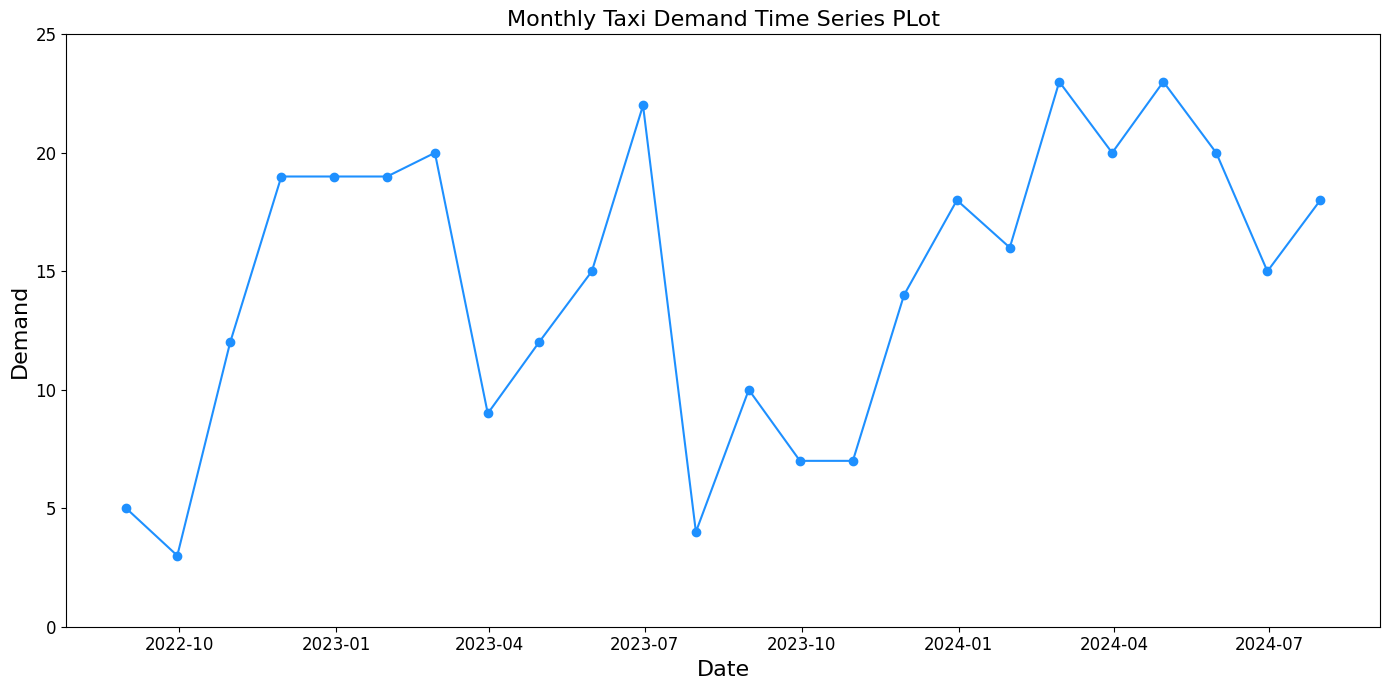

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data['DEMAND'], marker='o', color='dodgerblue', label='Demand')
plt.title('Monthly Taxi Demand Time Series PLot', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Demand', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 25)
plt.grid(False)
plt.tight_layout()
# plt.savefig('CHARTS/monthly_demand_time_series_plot.png', dpi=300)
plt.show()

## Seasonal Decomposition of Monthly Demand

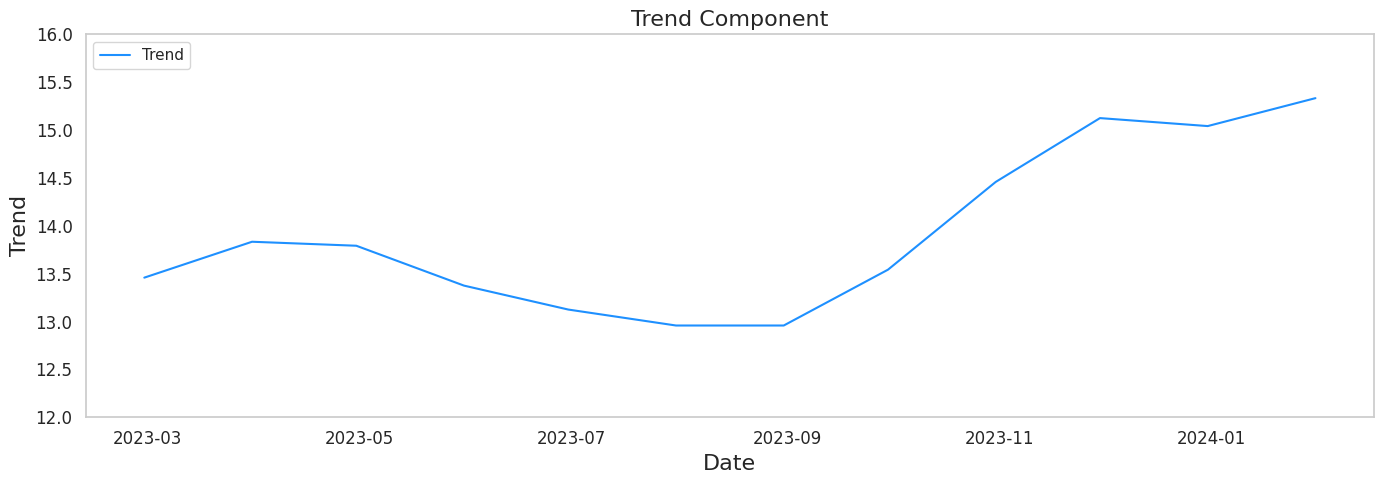

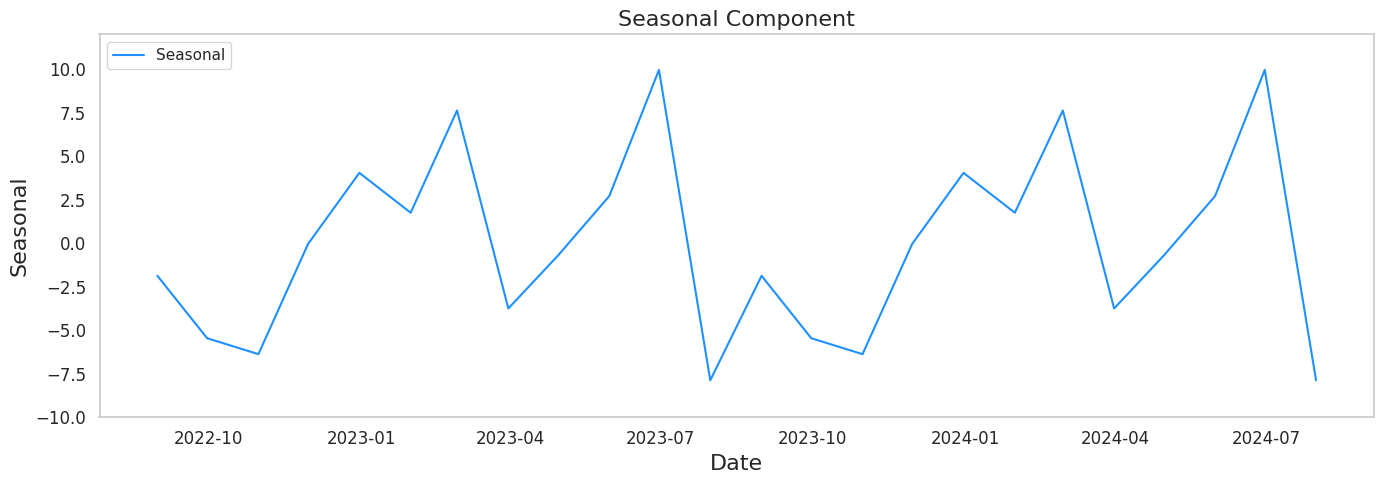

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the aesthetic style
sns.set(style="whitegrid")

# Decompose the time series
decomposition = seasonal_decompose(monthly_demand, model='additive')


# Save individual components
plt.figure(figsize=(14, 5))

# Save trend component
plt.plot(decomposition.trend, label='Trend', color='dodgerblue')
plt.legend(loc='upper left')
plt.title('Trend Component', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Trend', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(12, 16)
plt.grid(False)
plt.tight_layout()
# plt.savefig('CHARTS/trend_component.png', format='png', dpi=300)

# Save seasonal component
plt.figure(figsize=(14, 5))
plt.plot(decomposition.seasonal, label='Seasonal', color='dodgerblue')
plt.legend(loc='upper left')
plt.title('Seasonal Component', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Seasonal', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-10, 12)
plt.grid(False)
plt.tight_layout()
# plt.savefig('CHARTS/seasonal_component.png', format='png', dpi=300)

# Show all plots
plt.show()

## Augmented Dickey-Fuller Test for Stationarity

In [41]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(monthly_demand)

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis. The time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The time series is likely non-stationary.")


ADF Statistic: -3.485459071416965
p-value: 0.00836848389556238
Critical Values:
   1%: -4.01203360058309
   5%: -3.1041838775510207
   10%: -2.6909873469387753
Reject the null hypothesis. The time series is likely stationary.


## ACF & PACF Plots

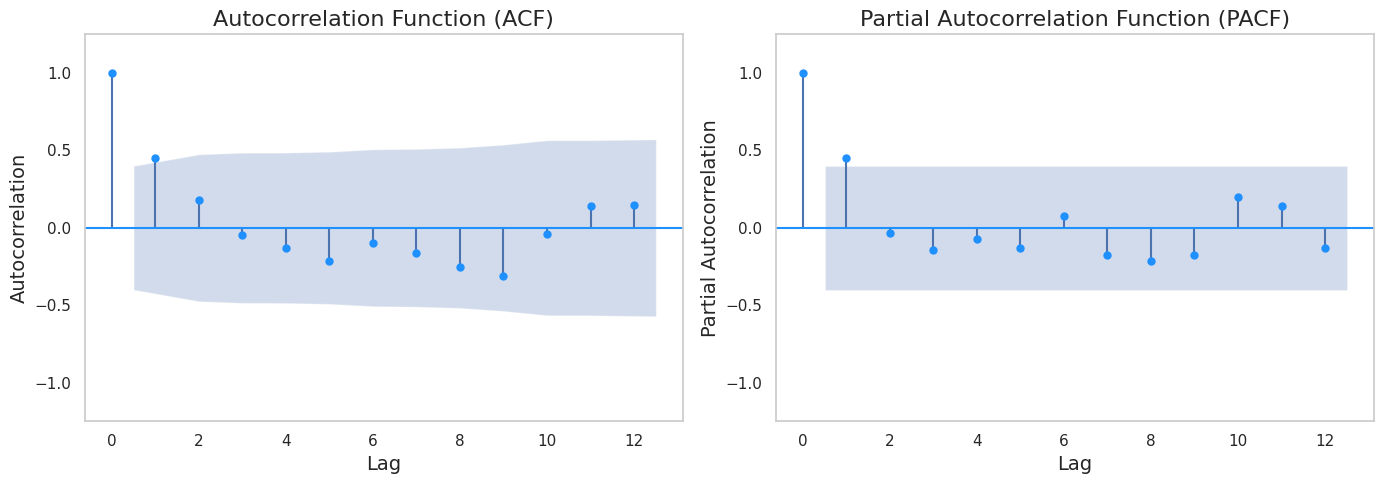

In [42]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot ACF
plot_acf(monthly_demand, ax=axes[0], lags=12, color='dodgerblue')
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=16)
axes[0].set_xlabel('Lag', fontsize=14)
axes[0].set_ylabel('Autocorrelation', fontsize=14)
axes[0].grid(False)  # No grid
axes[0].set_ylim(-1.25, 1.25)  # Set y-axis limits

# Plot PACF
plot_pacf(monthly_demand, ax=axes[1], lags=12, color='dodgerblue')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=16)
axes[1].set_xlabel('Lag', fontsize=14)
axes[1].set_ylabel('Partial Autocorrelation', fontsize=14)
axes[1].grid(False)  # No grid
axes[1].set_ylim(-1.25, 1.25)  # Set y-axis limits

# Adjust layout and save
plt.tight_layout()
# plt.savefig('CHARTS/acf_pacf_plots.png', format='png', dpi=300)
plt.show()

## Exponential Smoothing

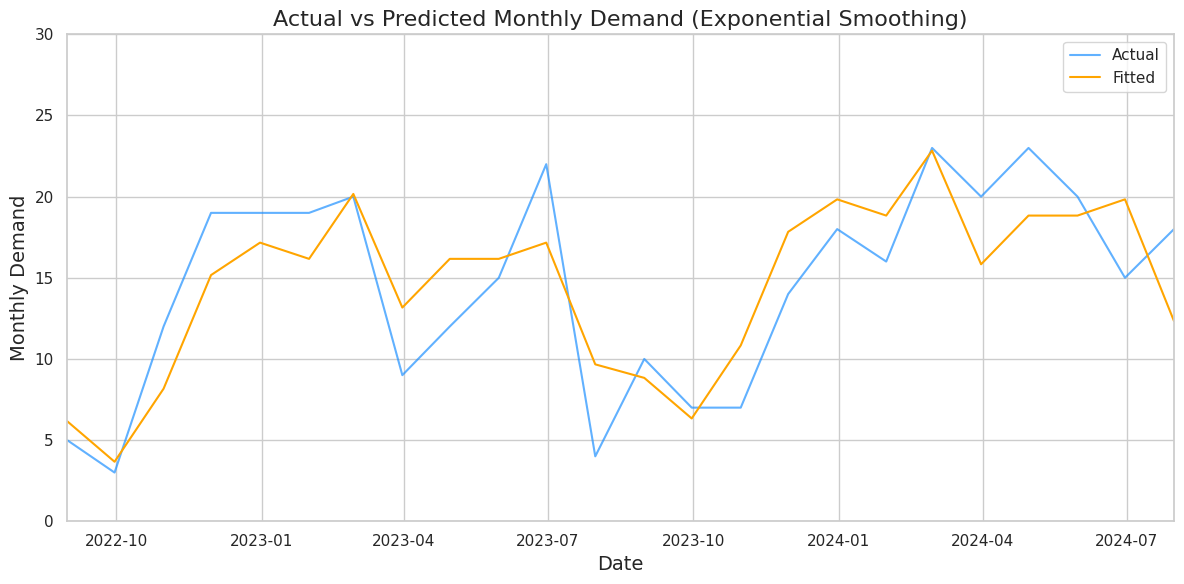

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Exponential Smoothing model
model_es = ExponentialSmoothing(monthly_demand, trend='add', seasonal='add', seasonal_periods=12).fit()

# Get in-sample predictions (fitted values) for the training period
train_predictions_es = model_es.fittedvalues

# Forecast future values
predictions_es = model_es.forecast(steps=8)

# Plot actual vs. predicted values
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(monthly_demand, label='Actual', color='dodgerblue', alpha=0.7)
plt.plot(train_predictions_es, label='Fitted', color='orange', alpha=1)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Demand', fontsize=14)
plt.title('Actual vs Predicted Monthly Demand (Exponential Smoothing)', fontsize=16)
plt.legend()
plt.grid(True)
plt.ylim(0, 30)
plt.xlim(monthly_demand.index[0], monthly_demand.index[-1])
plt.tight_layout()
# plt.savefig('CHARTS/actual_vs_predicted_es.png', format='png', dpi=300)
plt.show()

In [44]:
predictions_es

,0
2024-08-31,11.499969
2024-09-30,8.999969
2024-10-31,13.499946
2024-11-30,20.499950
2024-12-31,22.499965
2025-01-31,21.499955
2025-02-28,25.499972
2025-03-31,18.499946


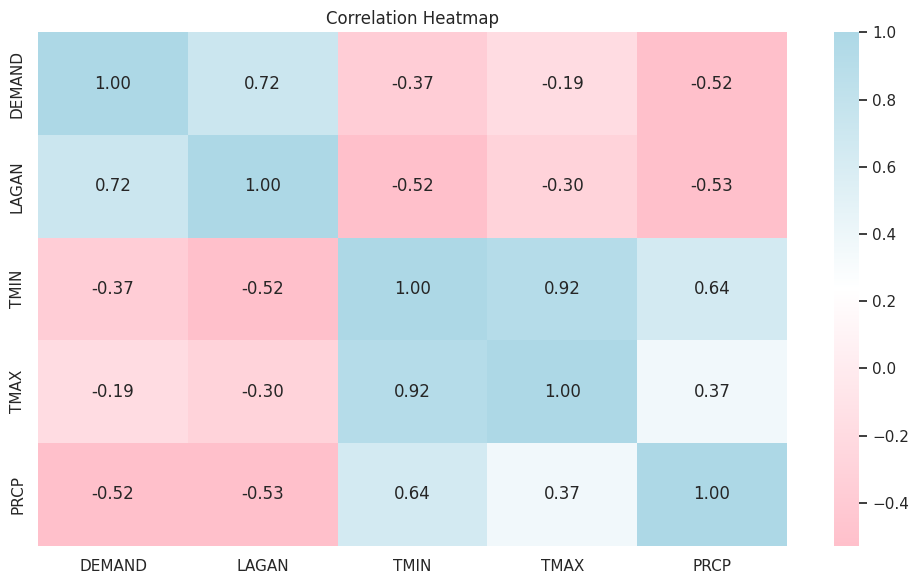

In [45]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom color map
custom_cmap = LinearSegmentedColormap.from_list(
    "pink_blue", ["pink", 'white', "lightblue"]
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_data.corr(), annot=True, cmap=custom_cmap, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
# Save the figure
# plt.savefig('CHARTS/correlation_heatmap_custom.png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

## XGBoost

In [46]:
X = monthly_data[['LAGAN', 'TMIN', 'TMAX', 'PRCP']]
y = monthly_data['DEMAND']
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X, y)
xgb_preds = xgb_model.predict(X)
future_dates = pd.date_range(start='2024-08-01', periods=5, freq='M')
future_X = pd.DataFrame({
    'LAGAN': [0.0, 0.0, 0.0, 11.0, 6.0],
    'TMIN': [27.0, 26.7, 23.9, 16.9, 14.4],
    'TMAX': [35.0, 34.2, 33.4, 29.6, 25.4],
    'PRCP': [1.1, 5.7, 4.6, 0.0, 0.3]
}, index=future_dates)

xgb_forecast = xgb_model.predict(future_X)
xgb_forecast

array([19.88982 ,  6.12464 ,  6.544521, 20.36831 , 18.980839],
      dtype=float32)

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [48]:
# Features and target
X = monthly_data[['LAGAN', 'TMIN', 'TMAX', 'PRCP']]
y = monthly_data['DEMAND']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [49]:
# Initialize and fit the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
# Predictions on the training set
y_train_pred = xgb_model.predict(X_train)

# Predictions on the test set
y_test_pred = xgb_model.predict(X_test)# Predictions on the training set

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'RMSE on Training Set: {rmse_train:.4f}')

# Calculate RMSE for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'RMSE on Test Set: {rmse_test:.4f}')

print(f'R-squared on Training Set: {r2_score(y_train, y_train_pred):.4f}')
print(f'R-squared on Test Set: {r2_score(y_test, y_test_pred):.4f}')

RMSE on Training Set: 0.0009
RMSE on Test Set: 3.3851
R-squared on Training Set: 1.0000
R-squared on Test Set: 0.5940


## Hyperparameter Tuned XGBoost

In [50]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=50,  # Reduce the number of trees
    learning_rate=0.1,  # Reduce learning rate
    max_depth=3,  # Limit tree depth
    subsample=0.8,  # Use a fraction of the data
    colsample_bytree=0.8,  # Use a fraction of features
    gamma=1,  # Regularization parameter
    reg_lambda=1,  # L2 regularization
    reg_alpha=0.5  # L1 regularization
)
xgb_model.fit(X_train, y_train)
# Predictions on the training set
y_train_pred = xgb_model.predict(X_train)

# Predictions on the test set
y_test_pred = xgb_model.predict(X_test)# Predictions on the training set

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'RMSE on Training Set: {rmse_train:.4f}')

# Calculate RMSE for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'RMSE on Test Set: {rmse_test:.4f}')

print(f'R-squared on Training Set: {r2_score(y_train, y_train_pred):.4f}')
print(f'R-squared on Test Set: {r2_score(y_test, y_test_pred):.4f}')

RMSE on Training Set: 1.0715
RMSE on Test Set: 1.9572
R-squared on Training Set: 0.9688
R-squared on Test Set: 0.8643


Residuals Distribution:
count    24.000000
mean     -0.151136
std       1.234548
min      -2.454064
25%      -1.075753
50%      -0.285561
75%       1.034702
max       1.534943
Name: DEMAND, dtype: float64


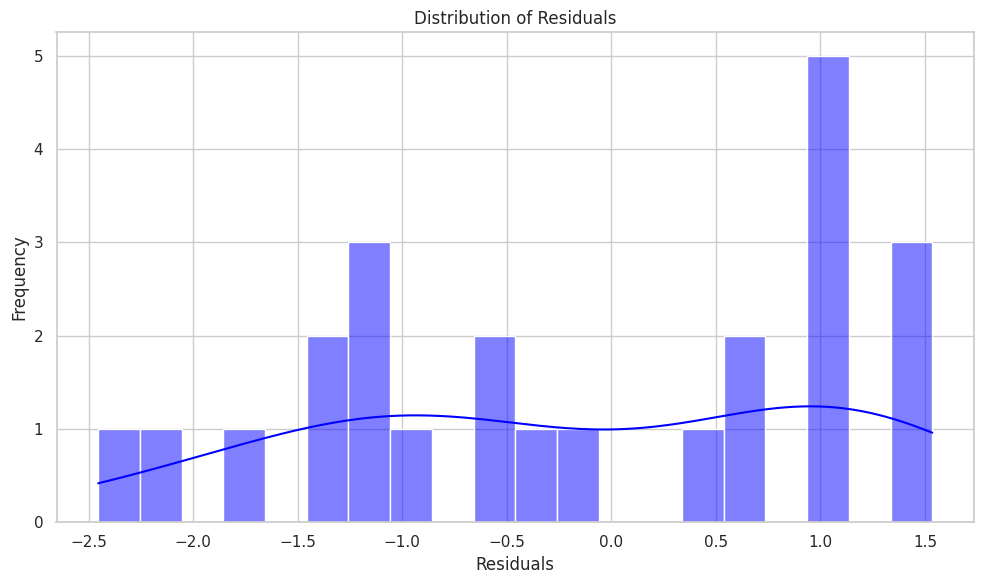

In [51]:
import numpy as np

# Predict on the entire dataset
y_pred_full = xgb_model.predict(X)

# Calculate residuals
residuals_full = y - y_pred_full

# Print the distribution of residuals
print("Residuals Distribution:")
print(residuals_full.describe())

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_full, kde=True, bins=20, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.tight_layout()
# plt.savefig('CHARTS/residuals_distribution_xgb.png', format='png', dpi=300)
plt.show()


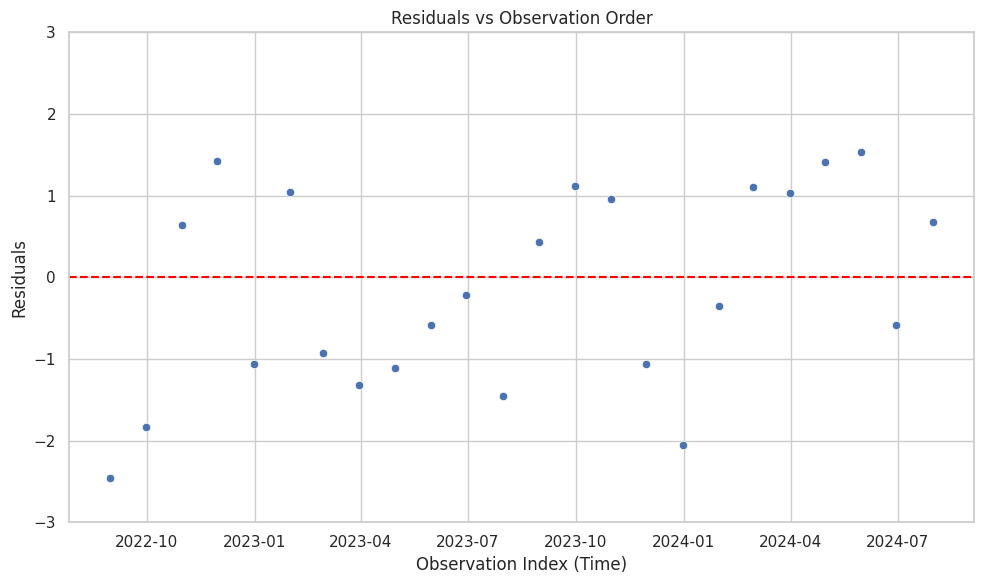

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y.index, y=residuals_full)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Observation Index (Time)')
plt.ylabel('Residuals')
plt.ylim(-3, 3)
plt.title('Residuals vs Observation Order')
plt.grid(True)
plt.tight_layout()
# plt.savefig('CHARTS/residuals_vs_time.png', format='png', dpi=300)
plt.show()


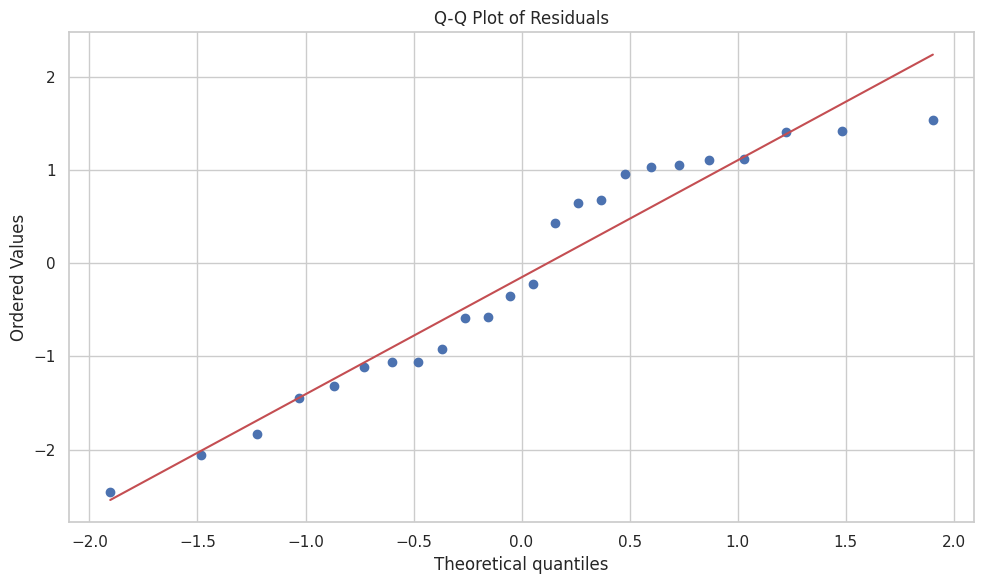

In [53]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals_full, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
# plt.savefig('CHARTS/qq_plot_residuals.png', format='png', dpi=300)
plt.show()


In [54]:
future_dates = pd.date_range(start='2024-08-01', periods=5, freq='M')
future_X = pd.DataFrame({
    'LAGAN': [0.0, 0.0, 0.0, 11.0, 6.0],
    'TMIN': [27.0, 26.7, 23.9, 16.9, 14.4],
    'TMAX': [35.0, 34.2, 33.4, 29.6, 25.4],
    'PRCP': [1.1, 5.7, 4.6, 0.0, 0.3]
}, index=future_dates)

# Predict future demand
xgb_forecast = xgb_model.predict(future_X)
print(f'Future Predictions: {xgb_forecast}')


Future Predictions: [12.806013   5.409524   7.4143586 20.925735  17.39096  ]


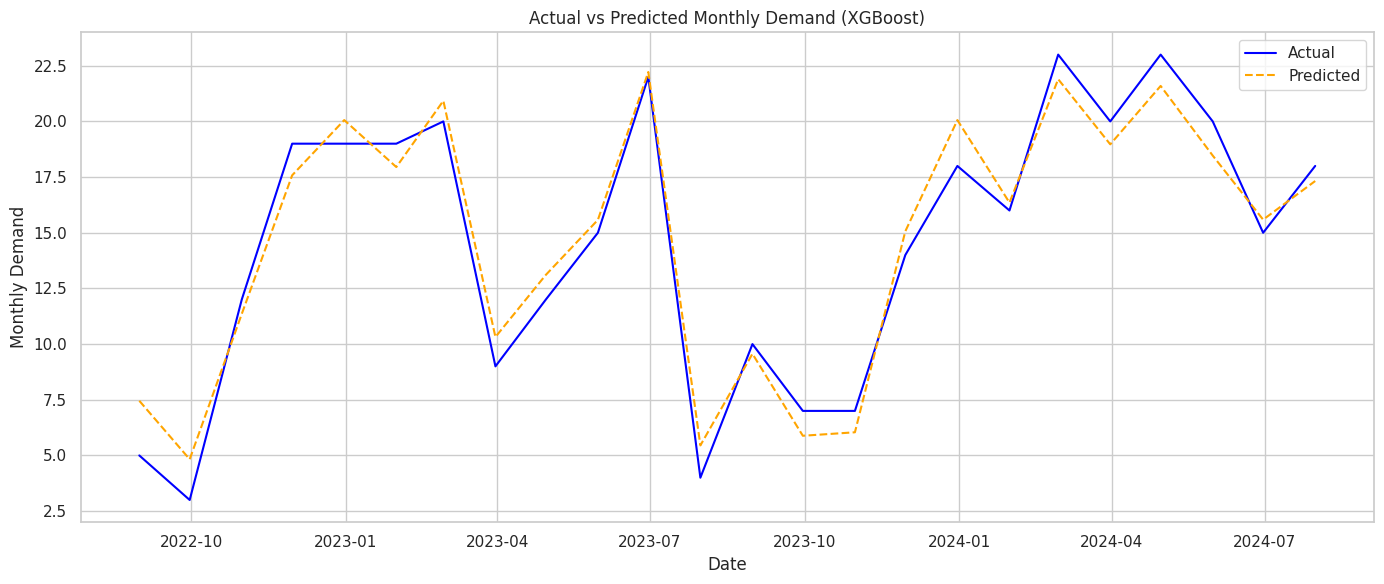

In [55]:
import matplotlib.pyplot as plt

# Predict on the entire training data
y_train_pred_full = xgb_model.predict(X)

# Plot actual vs. predicted values
plt.figure(figsize=(14, 6))
plt.plot(y.index, y, label='Actual', color='blue')
plt.plot(y.index, y_train_pred_full, label='Predicted', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Monthly Demand')
plt.title('Actual vs Predicted Monthly Demand (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('CHARTS/actual_vs_predicted_xgb.png', format='png', dpi=300)
plt.show()


# Advanced Demand Forecasting Model

In [56]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Your full dataset
X = monthly_data[['LAGAN', 'TMIN', 'TMAX', 'PRCP']]
y = monthly_data['DEMAND']

# Train the SARIMA model on the entire dataset
sarima_model = SARIMAX(y, exog=X['LAGAN'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Generate in-sample predictions with SARIMA
sarima_in_sample_preds = sarima_fit.predict(start=0, end=len(y) - 1, exog=X['LAGAN'])

# Fit the Exponential Smoothing model on the entire dataset
model_es = ExponentialSmoothing(y, trend='add', seasonal='add', seasonal_periods=12).fit()

# Generate in-sample predictions with Exponential Smoothing
es_in_sample_preds = model_es.fittedvalues

# Forecast future values using Exponential Smoothing
es_forecast = model_es.forecast(steps=5)

# Train the XGBoost model on the entire dataset
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=50,  # Reduce the number of trees
    learning_rate=0.1,  # Reduce learning rate
    max_depth=3,  # Limit tree depth
    subsample=0.8,  # Use a fraction of the data
    colsample_bytree=0.8,  # Use a fraction of features
    gamma=1,  # Regularization parameter
    reg_lambda=1,  # L2 regularization
    reg_alpha=0.5  # L1 regularization
)
xgb_model.fit(X, y)

# Generate in-sample predictions with XGBoost
xgb_in_sample_preds = xgb_model.predict(X)

# Combine in-sample predictions for the ensemble
ensemble_in_sample_preds = (0.3 * sarima_in_sample_preds + 0.4 * xgb_in_sample_preds + 0.3 * es_in_sample_preds)

# Future exogenous variables (these should be known or forecasted for the future)
future_dates = pd.date_range(start='2024-08-01', periods=5, freq='M')
future_X = pd.DataFrame({
    'LAGAN': [0.0, 0.0, 0.0, 11.0, 6.0],  # Replace with your future values
    'TMIN': [27.0, 26.7, 23.9, 16.9, 14.4],  # Replace with your future values
    'TMAX': [35.0, 34.2, 33.4, 29.6, 25.4],  # Replace with your future values
    'PRCP': [1.1, 5.7, 4.6, 0.0, 0.3]  # Replace with your future values
}, index=future_dates)

# Make predictions for future demand using SARIMA
sarima_forecast = sarima_fit.get_forecast(steps=5, exog=future_X['LAGAN']).predicted_mean

# Make predictions for future demand using XGBoost
xgb_forecast = xgb_model.predict(future_X)

# Combine the predictions for the ensemble
ensemble_forecast = (0.3 * sarima_forecast + 0.4 * xgb_forecast + 0.3 * es_forecast)

# Combine historical data with forecasts
combined_df = pd.DataFrame({
    'Actual_Demand': y,
    'SARIMA_Predicted_Demand': sarima_in_sample_preds,
    'Exponential_Smoothing_Predicted_Demand': es_in_sample_preds,
    'XGBoost_Predicted_Demand': xgb_in_sample_preds,
    'Ensemble_Predicted_Demand': ensemble_in_sample_preds
}, index=monthly_data.index)

# Append the future predictions to the combined dataframe
forecast_df = pd.DataFrame({
    'SARIMA_Predicted_Demand': sarima_forecast,
    'Exponential_Smoothing_Predicted_Demand': es_forecast,
    'XGBoost_Predicted_Demand': xgb_forecast,
    'Ensemble_Predicted_Demand': ensemble_forecast
}, index=future_dates)

# Concatenate the in-sample predictions with future forecasts
combined_df = pd.concat([combined_df, forecast_df])


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


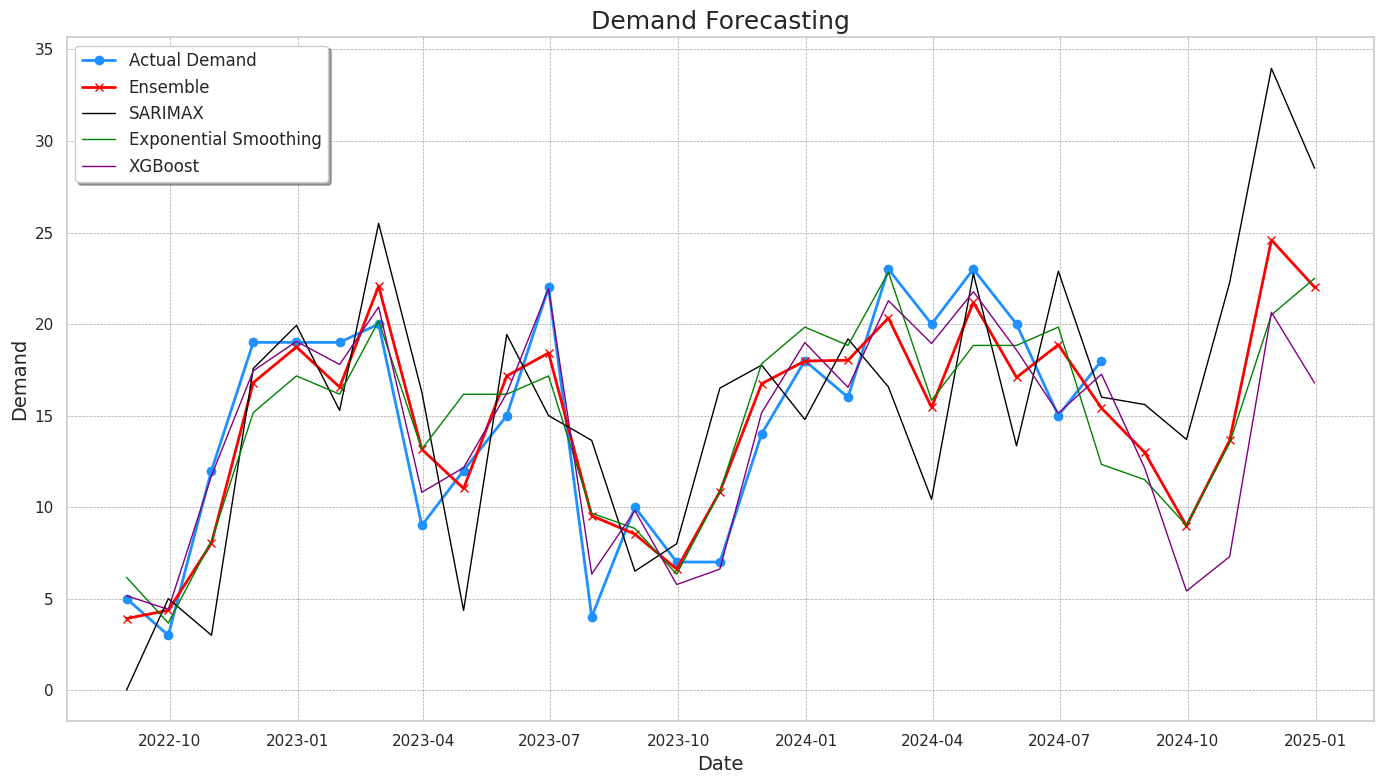

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("muted")

# Create the plot
plt.figure(figsize=(14, 8))

# Plot actual demand
plt.plot(combined_df.index, combined_df['Actual_Demand'], label='Actual Demand', marker='o', color='dodgerblue', linewidth=2)

# Plot ensemble predicted demand
plt.plot(combined_df.index, combined_df['Ensemble_Predicted_Demand'], label='Ensemble', marker='x', color='red', linestyle='-', linewidth=2)

# Plot SARIMA predicted demand
plt.plot(combined_df.index, combined_df['SARIMA_Predicted_Demand'], label='SARIMAX', linestyle='-', color='black', linewidth=1)

# Plot Exponential Smoothing predicted demand
plt.plot(combined_df.index, combined_df['Exponential_Smoothing_Predicted_Demand'], label='Exponential Smoothing', linestyle='-', color='green', linewidth=1)


plt.plot(combined_df.index, combined_df['XGBoost_Predicted_Demand'], label='XGBoost', linestyle='-', color='purple', linewidth=1)
# Customize the legend
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)

# Add title and labels
plt.title('Demand Forecasting', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Demand', fontsize=14)

# Beautify the grid
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()
# Save the plot
# plt.savefig('CHARTS/advanced_demand_forecast.png', format='png', dpi=300)
# Show the plot
plt.show()

In [58]:
for col in forecast_df.columns:
    print(col, forecast_df[col].mean(), forecast_df[col].var())

SARIMA_Predicted_Demand 22.80711382299969 73.06019664127835
Exponential_Smoothing_Predicted_Demand 15.399959636379782 34.04995789508041
XGBoost_Predicted_Demand 12.45282 40.51444
Ensemble_Predicted_Demand 16.44324963371533 43.27408859931923


In [59]:
for col in forecast_df.columns:
    print(col, combined_df[col].mean(), combined_df[col].var())

SARIMA_Predicted_Demand 15.646957095218934 58.201758024817835
Exponential_Smoothing_Predicted_Demand 14.724108344107194 27.08784497811755
XGBoost_Predicted_Demand 14.209206 33.260227
Ensemble_Predicted_Demand 14.795002048845275 29.97171637983299


In [60]:
# prompt: calucalte r2 score of each col in combined_df with Actual_Demand

for col in ['SARIMA_Predicted_Demand', 'Exponential_Smoothing_Predicted_Demand', 'XGBoost_Predicted_Demand', 'Ensemble_Predicted_Demand']:
  # Extract predicted and observed values, aligning indices
  pred_values = combined_df[col][:-5].values  # Exclude future predictions
  observed_values = combined_df['Actual_Demand'][:-5].values  # Exclude future actual values

  # Calculate R-squared score
  r2 = r2_score(observed_values, pred_values)
  print(f"R-squared score for {col}: {r2}")


R-squared score for SARIMA_Predicted_Demand: 0.08577755850779734
R-squared score for Exponential_Smoothing_Predicted_Demand: 0.6977660926994527
R-squared score for XGBoost_Predicted_Demand: 0.9666723289792788
R-squared score for Ensemble_Predicted_Demand: 0.7857170534199615


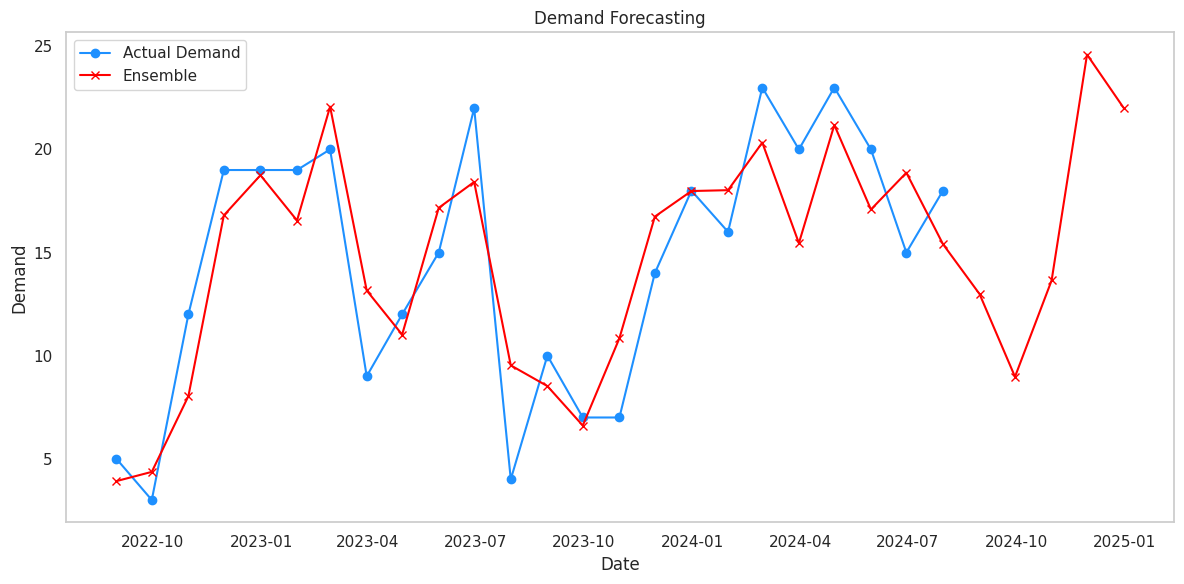

In [61]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual demand
plt.plot(combined_df.index, combined_df['Actual_Demand'], label='Actual Demand', marker='o', color='dodgerblue')

# Plot ensemble predicted demand
# plt.plot(combined_df.index, combined_df['Ensemble_Predicted_Demand'], label='Ensemble Predicted Demand', marker='x', color='red')

# Plot SARIMA predicted demand
plt.plot(combined_df.index, combined_df['Ensemble_Predicted_Demand'], label='Ensemble', linestyle='-', color='red', marker='x')

# Plot Exponential Smoothing predicted demand
# plt.plot(combined_df.index, combined_df['Exponential_Smoothing_Predicted_Demand'], label='Exponential Smoothing Predicted Demand', linestyle='-.', color='green')

# Uncomment if you want to include XGBoost predicted demand as well
# plt.plot(combined_df.index, combined_df['XGBoost_Predicted_Demand'], label='XGBoost Predicted Demand', linestyle='-', color='pink')

# Add legend, title, and labels
plt.legend()
plt.title('Demand Forecasting')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.grid(False)
plt.tight_layout()
# Save the plot
# plt.savefig('CHARTS/ensemble_demand_forecasting.png', format='png', dpi=300)

# Show plot
plt.show()


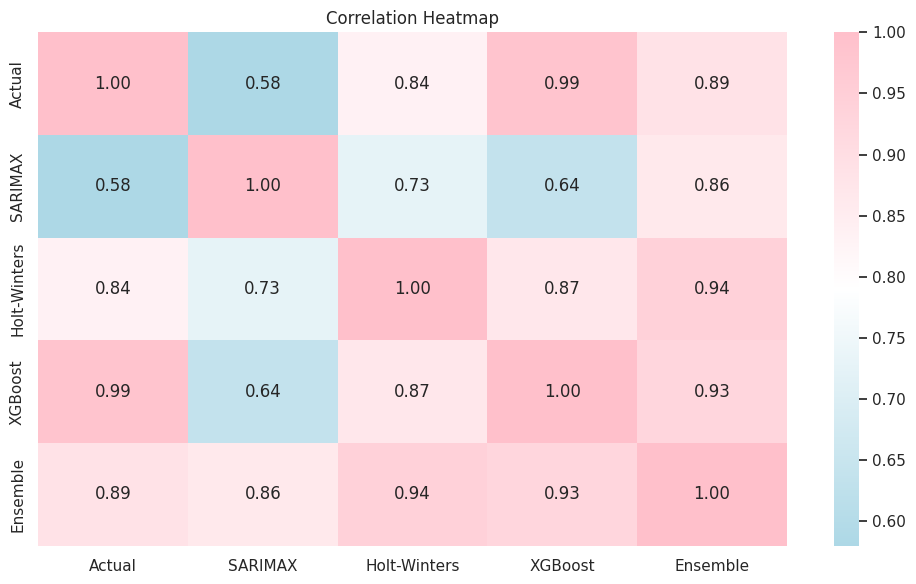

In [62]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom color map
custom_cmap = LinearSegmentedColormap.from_list(
    "pink_blue", ['lightblue', 'white', 'pink']
)
combined_df = pd.DataFrame({
    'Actual': y,
    'SARIMAX': sarima_in_sample_preds,
    'Holt-Winters': es_in_sample_preds,
    'XGBoost': xgb_in_sample_preds,
    'Ensemble': ensemble_in_sample_preds
}, index=monthly_data.index)
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(combined_df.corr(), annot=True, cmap=custom_cmap, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
# Save the figure
# plt.savefig('CHARTS/predictions_correlation_heatmap.png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

# Dynamic Pricing Model

In [63]:
df.head()

,DEMAND,FROM,TO,DISTANCE,PROFIT,LAGAN,TMIN,TMAX,PRCP,FUEL_COST,EFFICIENCY
DATE,,,,,,,,,,,
2024-07-22,1.0,Masaurhi,Unknown,132.0,1000.0,0.0,31.0,36.0,0.6,809.864000,1.234775
2024-07-21,1.0,Masaurhi,Unknown,46.0,1000.0,0.0,31.0,35.0,0.4,282.225333,3.543268
2024-07-17,1.0,Masaurhi,Unknown,122.0,1000.0,0.0,29.2,37.0,0.0,748.510667,1.335986
2024-07-16,1.0,Masaurhi,Unknown,59.0,1000.0,0.0,29.6,35.0,0.0,361.984667,2.762548
2024-07-15,1.0,Masaurhi,Unknown,83.8,3000.0,1.0,28.8,37.0,5.1,514.140933,5.834976


In [64]:
df.reset_index(inplace=True)

## Linear Regression

In [65]:
def prepare_dataset(data):

    # Extract 'MONTH' and 'YEAR' from 'DATE' column
    data['DATE'] = pd.to_datetime(data['DATE'])
    data['MONTH'] = data['DATE'].dt.month
    data['YEAR'] = data['DATE'].dt.year

    # Aggregate 'DEMAND' and 'LAGAN' to monthly totals
    monthly_aggregates = data.groupby(['YEAR', 'MONTH']).agg({
        'DEMAND': 'sum',
        'LAGAN': 'sum'
    }).rename(columns={'DEMAND': 'MONTHLY_DEMAND', 'LAGAN': 'MONTHLY_LAGAN'}).reset_index()

    # Merge monthly aggregates back to the main dataset
    data = pd.merge(data, monthly_aggregates, on=['YEAR', 'MONTH'], how='left')

    column_order = [
        'DISTANCE',
        'TMIN', 'TMAX', 'PRCP', 'EFFICIENCY',
        'MONTH', 'MONTHLY_DEMAND', 'MONTHLY_LAGAN', 'PROFIT'
    ]
    data = data[column_order].rename(columns={'MONTHLY_DEMAND': 'DEMAND', 'MONTHLY_LAGAN': 'LAGAN'})

    return data
reg_data = prepare_dataset(df)
reg_data.head()

,DISTANCE,TMIN,TMAX,PRCP,EFFICIENCY,MONTH,DEMAND,LAGAN,PROFIT
0,132.0,31.0,36.0,0.6,1.234775,7,18.0,5.0,1000.0
1,46.0,31.0,35.0,0.4,3.543268,7,18.0,5.0,1000.0
2,122.0,29.2,37.0,0.0,1.335986,7,18.0,5.0,1000.0
3,59.0,29.6,35.0,0.0,2.762548,7,18.0,5.0,1000.0
4,83.8,28.8,37.0,5.1,5.834976,7,18.0,5.0,3000.0


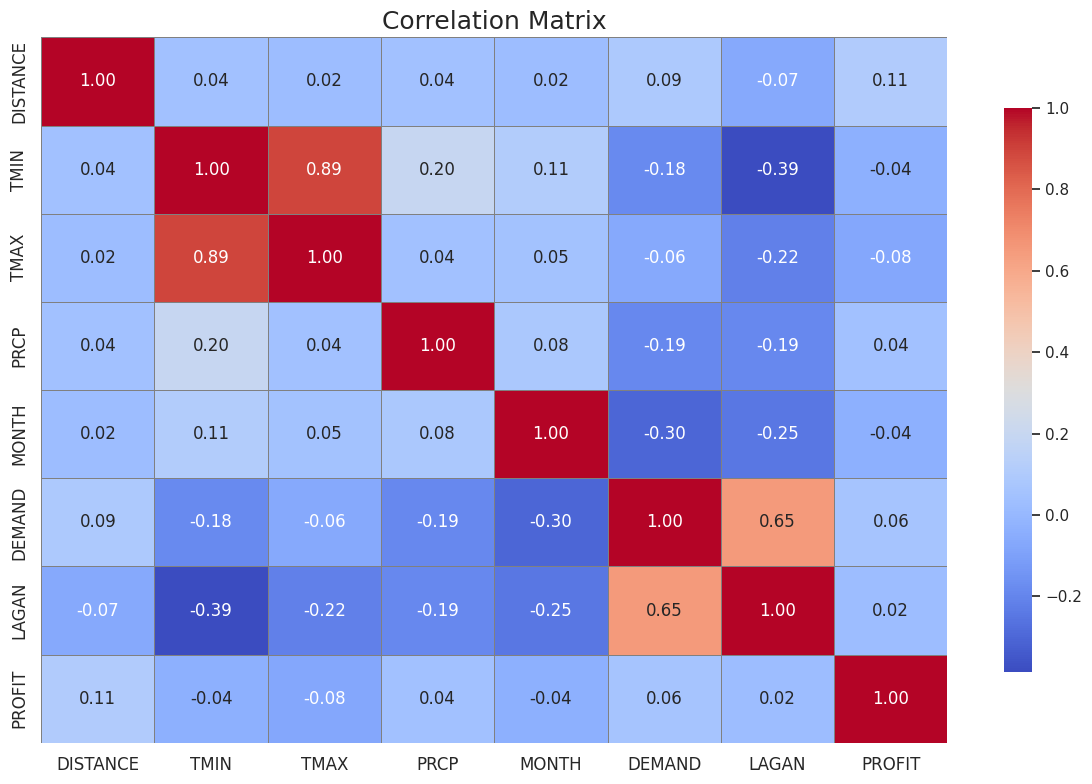

In [66]:
# prompt: correlation heatmap for reg_data

import matplotlib.pyplot as plt
# Compute the correlation matrix
corr = reg_data.drop(columns=['EFFICIENCY']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'shrink': .8}, linewidths=0.5, linecolor='gray')

# Add title and labels
plt.title('Correlation Matrix', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to make room for the labels
plt.tight_layout()

# Save the heatmap
# plt.savefig('CHARTS/correlation_heatmap_reg_data.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


Train Root Mean Squared Error: 442.68214846980607
Test Root Mean Squared Error: 597.6808181394974


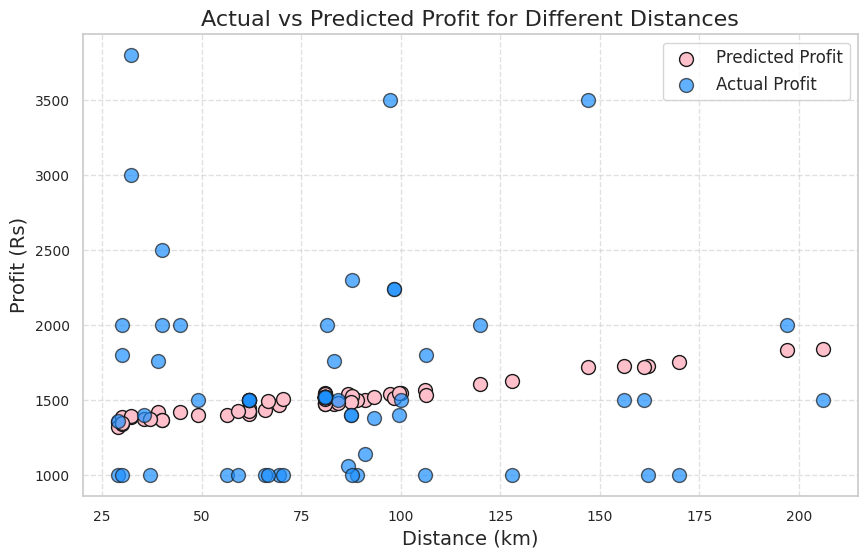

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare data
X = reg_data.drop(columns=['PROFIT', 'EFFICIENCY', 'LAGAN'], axis=1)
y = reg_data['PROFIT']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
print(f'Train Root Mean Squared Error: {mean_squared_error(y_train, y_pred_train)**0.5}')
print(f'Test Root Mean Squared Error: {mean_squared_error(y_test, y_pred_test)**0.5}')

# Plot
plt.figure(figsize=(10, 6))

# Scatter plot for predicted profit
plt.scatter(X_test['DISTANCE'], y_pred_test, color='pink', edgecolor='k', alpha=1, s=100, label='Predicted Profit')

# Scatter plot for actual profit
plt.scatter(X_test['DISTANCE'], y_test, color='dodgerblue', edgecolor='k', alpha=0.7, s=100, label='Actual Profit')

# Add legend
plt.legend(title='', fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and title with custom fonts and sizes
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Profit (Rs)', fontsize=14)
plt.title('Actual vs Predicted Profit for Different Distances', fontsize=16)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the plot (optional)
# plt.savefig('CHARTS/distance_vs_profit.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


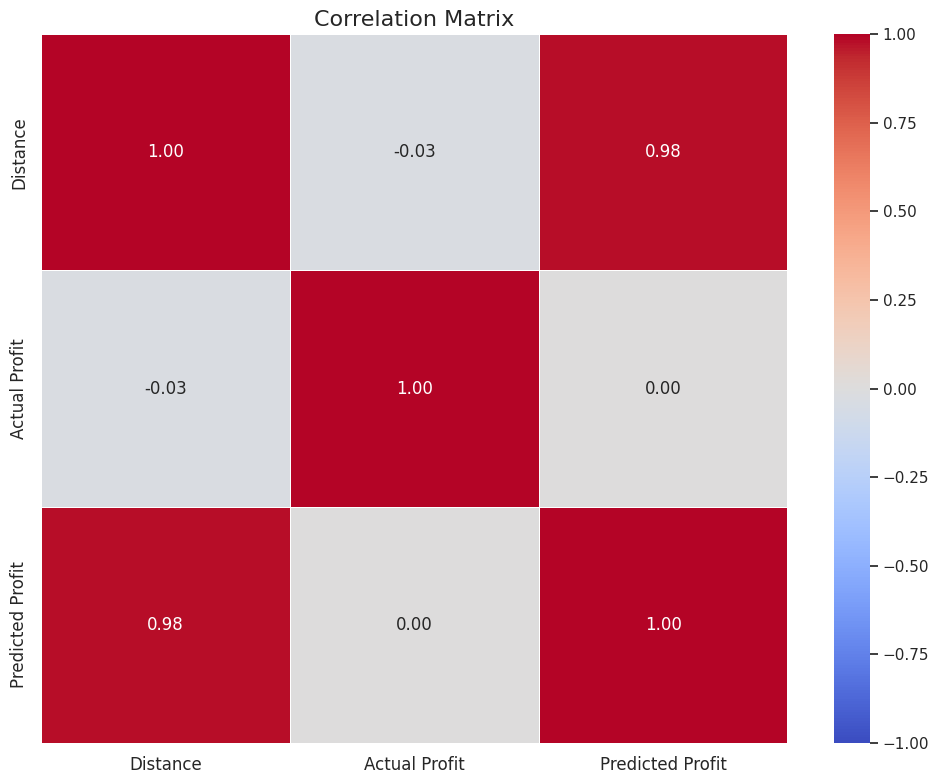

In [68]:
df_corr = pd.DataFrame({
    'Distance': X_test['DISTANCE'],
    'Actual Profit': y_test,
    'Predicted Profit': y_pred_test
})
# Compute the correlation matrix
corr = df_corr.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1, center=0)

# Customize the plot
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the plot
# plt.savefig('CHARTS/actual_vs_predicted_profit_corr_mat.png', format='png', dpi=300)

# Show the plot
plt.show()

In [69]:
X.columns

Index(['DISTANCE', 'TMIN', 'TMAX', 'PRCP', 'MONTH', 'DEMAND'], dtype='object')

In [70]:
model.coef_

array([ 2.87156883, -0.78855849, -1.7319557 , -0.04214696, -0.57196401,
        2.393106  ])

In [71]:
model.intercept_

1302.428556080165

In [72]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_
})
feature_importance

,Feature,Importance
0,DISTANCE,2.871569
1,TMIN,-0.788558
2,TMAX,-1.731956
3,PRCP,-0.042147
4,MONTH,-0.571964
5,DEMAND,2.393106


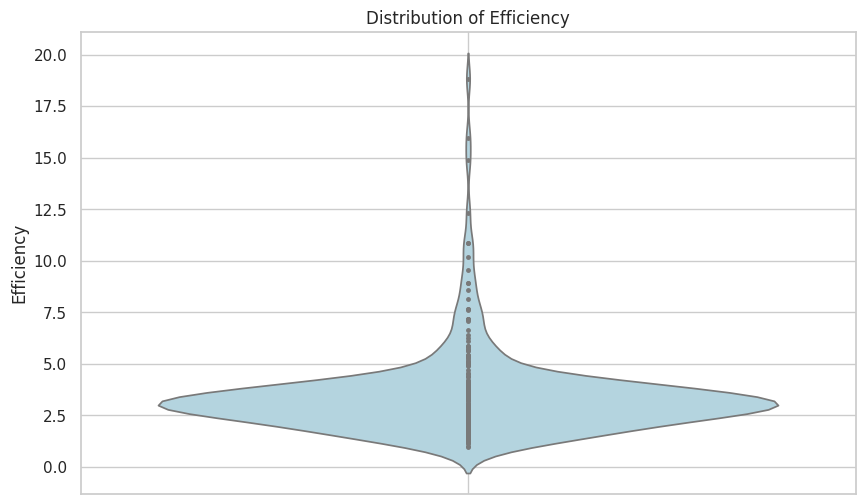

In [73]:
# prompt: violin plot of df.efficiency

import matplotlib.pyplot as plt
# Plot the distribution of 'EFFICIENCY'
plt.figure(figsize=(10, 6))
sns.violinplot(y=df['EFFICIENCY'], inner="points", color='lightblue')
plt.title('Distribution of Efficiency')
plt.ylabel('Efficiency')
plt.grid(True)
plt.show()


In [74]:
df.EFFICIENCY.describe()

,EFFICIENCY
count,350.000000
mean,3.437740
std,2.013355
min,0.958767
25%,2.469550
50%,2.996793
75%,3.872343
max,18.827764


*Split the data based on efficiency to train regularized MLR OLS and Random Forest*

## Regularized MLR OLS

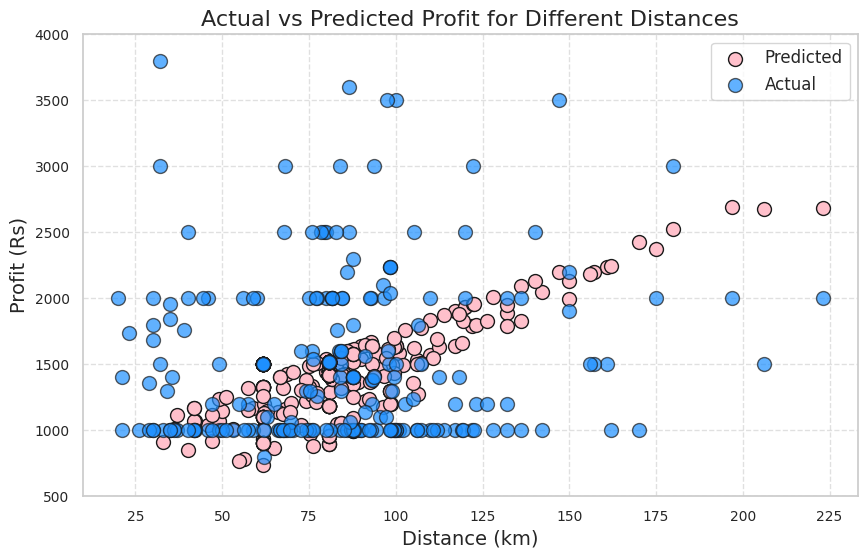

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

lr_data = reg_data[reg_data['EFFICIENCY'] < 5]
# Prepare data
X = lr_data.drop(columns=['PROFIT', 'EFFICIENCY', 'LAGAN', 'TMAX', 'TMIN', 'PRCP', 'MONTH'], axis=1)
y = lr_data['PROFIT']

# Initialize and train the model
model = Ridge(alpha=100.0, fit_intercept=False)
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(10, 6))


# Scatter plot for predicted profit
plt.scatter(X['DISTANCE'], y_pred, color='pink', edgecolor='k', alpha=1, s=100, label='Predicted')
# Scatter plot for actual profit
plt.scatter(df.DISTANCE, df.PROFIT, color='dodgerblue', edgecolor='k', alpha=0.7, s=100, label='Actual')

# Add legend
plt.legend(title='', fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and title with custom fonts and sizes
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Profit (Rs)', fontsize=14)
plt.title('Actual vs Predicted Profit for Different Distances', fontsize=16)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(500, 4000)

# Save the plot (optional)
# plt.savefig('CHARTS/distance_vs_profit_lr.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [76]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_
})
feature_importance

,Feature,Importance
0,DISTANCE,9.826963
1,DEMAND,32.719510


In [77]:
model.predict(np.array([[100, 10]]))

array([1309.89136106])

## Random Forest Regressor

In [78]:
if 'DATE' not in df.columns:
    df.reset_index(inplace=True)

In [79]:
df.EFFICIENCY.describe()

,EFFICIENCY
count,350.000000
mean,3.437740
std,2.013355
min,0.958767
25%,2.469550
50%,2.996793
75%,3.872343
max,18.827764


In [80]:
df.sample()

,DATE,DEMAND,FROM,TO,DISTANCE,PROFIT,LAGAN,TMIN,TMAX,PRCP,FUEL_COST,EFFICIENCY,MONTH,YEAR
231,2023-05-01,1.0,Masaurhi,Unknown,61.8,1500.0,0.0,21.1,31.0,22.1,387.3624,3.872343,5,2023


In [81]:
df.columns

Index(['DATE', 'DEMAND', 'FROM', 'TO', 'DISTANCE', 'PROFIT', 'LAGAN', 'TMIN',
       'TMAX', 'PRCP', 'FUEL_COST', 'EFFICIENCY', 'MONTH', 'YEAR'],
      dtype='object')

In [82]:
def prepare_dataset(data):

    # Extract 'MONTH' and 'YEAR' from 'DATE' column
    data['DATE'] = pd.to_datetime(data['DATE'])
    data['MONTH'] = data['DATE'].dt.month
    data['YEAR'] = data['DATE'].dt.year

    # Aggregate 'DEMAND' and 'LAGAN' to monthly totals
    monthly_aggregates = data.groupby(['YEAR', 'MONTH']).agg({
        'DEMAND': 'sum',
        'LAGAN': 'sum'
    }).rename(columns={'DEMAND': 'MONTHLY_DEMAND', 'LAGAN': 'MONTHLY_LAGAN'}).reset_index()

    # Merge monthly aggregates back to the main dataset
    data = pd.merge(data, monthly_aggregates, on=['YEAR', 'MONTH'], how='left')

    # data = data.rename(columns={'MONTHLY_DEMAND': 'DEMAND', 'MONTHLY_LAGAN': 'LAGAN'})

    return data
rf_df = prepare_dataset(df)
rf_df.head()

,DATE,DEMAND,FROM,TO,DISTANCE,PROFIT,LAGAN,TMIN,TMAX,PRCP,FUEL_COST,EFFICIENCY,MONTH,YEAR,MONTHLY_DEMAND,MONTHLY_LAGAN
0,2024-07-22,1.0,Masaurhi,Unknown,132.0,1000.0,0.0,31.0,36.0,0.6,809.864000,1.234775,7,2024,18.0,5.0
1,2024-07-21,1.0,Masaurhi,Unknown,46.0,1000.0,0.0,31.0,35.0,0.4,282.225333,3.543268,7,2024,18.0,5.0
2,2024-07-17,1.0,Masaurhi,Unknown,122.0,1000.0,0.0,29.2,37.0,0.0,748.510667,1.335986,7,2024,18.0,5.0
3,2024-07-16,1.0,Masaurhi,Unknown,59.0,1000.0,0.0,29.6,35.0,0.0,361.984667,2.762548,7,2024,18.0,5.0
4,2024-07-15,1.0,Masaurhi,Unknown,83.8,3000.0,1.0,28.8,37.0,5.1,514.140933,5.834976,7,2024,18.0,5.0


In [83]:
rf_df = rf_df[rf_df['EFFICIENCY'] > 2.5]
rf_df.drop(columns=['DEMAND', 'LAGAN', 'DATE', 'FUEL_COST', 'EFFICIENCY', 'YEAR', 'MONTH'], inplace=True)
rf_df.head()

,FROM,TO,DISTANCE,PROFIT,TMIN,TMAX,PRCP,MONTHLY_DEMAND,MONTHLY_LAGAN
1,Masaurhi,Unknown,46.0,1000.0,31.0,35.0,0.4,18.0,5.0
3,Masaurhi,Unknown,59.0,1000.0,29.6,35.0,0.0,18.0,5.0
4,Masaurhi,Unknown,83.8,3000.0,28.8,37.0,5.1,18.0,5.0
5,Masaurhi,Unknown,40.0,2500.0,30.0,35.0,14.6,18.0,5.0
6,Masaurhi,Barni,33.0,1000.0,30.0,36.0,6.3,18.0,5.0


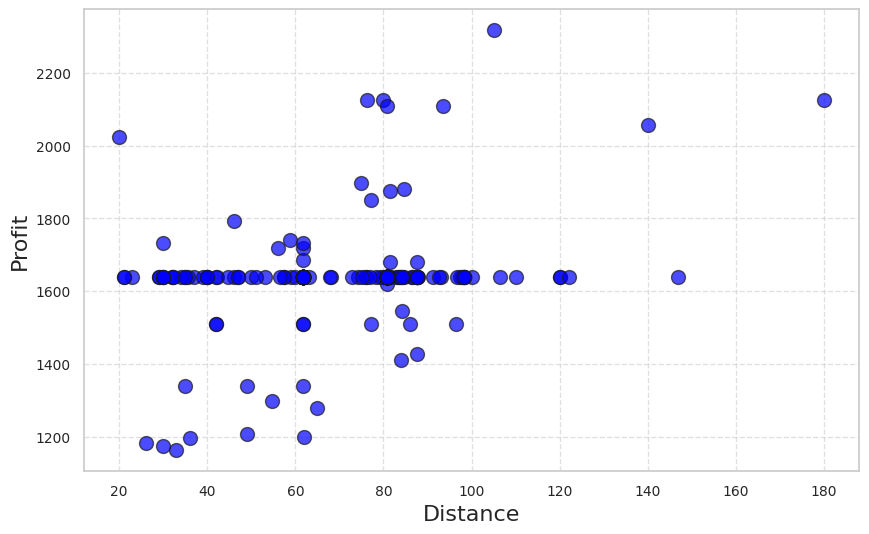

In [84]:
X = rf_df.drop('PROFIT', axis=1)
y = rf_df.PROFIT.copy()

# Define preprocessing steps
numeric_features = ['DISTANCE', 'MONTHLY_LAGAN', 'MONTHLY_DEMAND' 'TMIN', 'TMAX', 'PRCP']
categorical_features = ['FROM', 'TO']

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X['DISTANCE'], y_pred, color='blue', edgecolor='k', alpha=0.7, s=100)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and title with custom fonts and sizes
plt.xlabel('Distance', fontsize=16)
plt.ylabel('Profit', fontsize=16)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the plot
# plt.savefig('CHARTS/distance_vs_profit_rf.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [85]:
# prompt: correlation between y_pred and X['DISTANCE']

import numpy as np

# Assuming y_pred and X['DISTANCE'] are already defined

correlation = np.corrcoef(y_pred, X['DISTANCE'])[0, 1]
print("Correlation between y_pred and X['DISTANCE']: ", correlation)


Correlation between y_pred and X['DISTANCE']:  0.31113001936423396


# Route Optimization

In [86]:
location_df[location_df.LOCATION == 'Patna']

,LOCATION,LATITUDE,LONGITUDE
10,Patna,25.609324,85.123525


In [87]:
from folium.plugins import Draw
# Assuming location_df is a DataFrame with a 'Patna' entry containing 'LATITUDE' and 'LONGITUDE'
latitude = 25.609324
longitude = 85.123525

# Create a map centered on the given latitude and longitude
m = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add the Draw plugin to the map
draw = Draw(export=True)
draw.add_to(m)

# Display the map
m

In [88]:
vertices = {
    0: [25.353955, 85.039084],
    1: [25.364503, 85.151039],
    2: [25.446995, 85.175079],
    3: [25.473653, 85.096779],
    4: [25.495967, 84.955977],
    5: [25.562884, 85.038825],
    6: [25.583943, 85.129144],
    7: [25.584563, 85.19096]
}

edges = [
    (0, 1), (0, 3),
    (1, 2),
    (2, 3), (2, 7),
    (3, 6), (3, 4),
    (4, 5),
    (5, 6),
    (6, 7)
]

$$
d = 2R \cdot \arcsin \left( \sqrt{ \sin^2 \left( \frac{\Delta \phi}{2} \right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2 \left( \frac{\Delta \lambda}{2} \right) } \right)
$$

where:

- $\phi_1$ and $\phi_2$ are the latitudes of the two points in radians.
- $\Delta \phi$ is the difference between the latitudes of the two points ($\phi_2 - \phi_1$).
- $\Delta \lambda$ is the difference between the longitudes of the two points ($\lambda_2 - \lambda_1$).
- $R$ is the Earth's radius (mean radius = 6,371 km).

In [89]:
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# Create the graph dictionary with distances
graph = {}

for v1, coords1 in vertices.items():
    graph[v1] = {}
    for v2, coords2 in vertices.items():
        if v1 != v2:
            if (v1, v2) in edges or (v2, v1) in edges:
                distance = haversine(coords1[0], coords1[1], coords2[0], coords2[1])
                graph[v1][v2] = distance

# Output the graph
graph

{0: {1: 11.310241241519016, 3: 14.516482341442897},
 1: {0: 11.310241241519016, 2: 9.485179792596778},
 2: {1: 9.485179792596778, 3: 8.401318121058504, 7: 15.379654374126812},
 3: {0: 14.516482341442897,
  2: 8.401318121058504,
  4: 14.34923048659567,
  6: 12.686374038952177},
 4: {3: 14.34923048659567, 5: 11.156570188759579},
 5: {4: 11.156570188759579, 6: 9.356878318908054},
 6: {3: 12.686374038952177, 5: 9.356878318908054, 7: 6.200058403637336},
 7: {2: 15.379654374126812, 6: 6.200058403637336}}

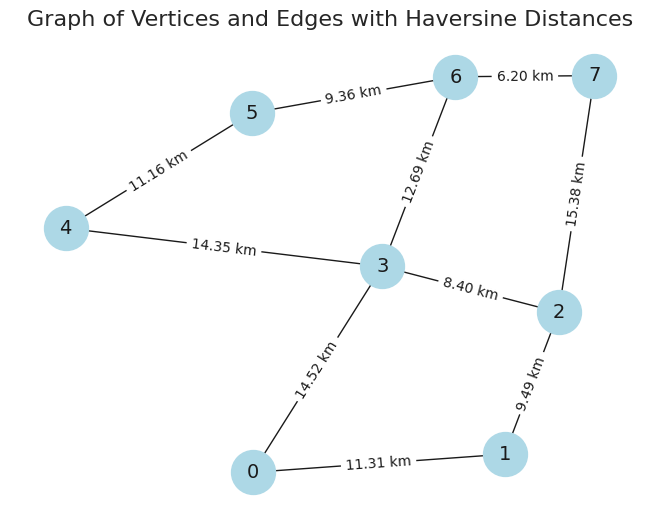

In [90]:
import networkx as nx

# Create a graph object
G = nx.Graph()

# Add nodes with position as attributes
for vertex, (lat, lon) in vertices.items():
    G.add_node(vertex, pos=(lon, lat))

# Add edges with weights
for edge in edges:
    v1, v2 = edge
    lat1, lon1 = vertices[v1]
    lat2, lon2 = vertices[v2]
    distance = haversine(lat1, lon1, lat2, lon2)
    G.add_edge(v1, v2, weight=distance)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, 'weight')

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=14)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f} km" for u, v, d in G.edges(data=True)})

# Show the plot
plt.title("Graph of Vertices and Edges with Haversine Distances", fontsize=16)
plt.tight_layout()
# plt.savefig('CHARTS/graph_with_distances.png', format='png', dpi=300)
plt.show()

In [91]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def get_coordinates(loc):
    user_agent = "sugamsawaarigeocoder" + str(random.randint(1,100))
    geolocator = Nominatim(user_agent=user_agent)
    location = geolocator.geocode(loc + ', ' + 'Bihar' + ', ' + 'India')
    if location:
        return (location.latitude, location.longitude)
    else:
        raise ValueError(f"Location '{loc}' not found.")

def shortest_route_to_patna(source, destination):
    # Define the vertices and edges
    vertices = {
        0: [25.353955, 85.039084],
        1: [25.364503, 85.151039],
        2: [25.446995, 85.175079],
        3: [25.473653, 85.096779],
        4: [25.495967, 84.955977],
        5: [25.562884, 85.038825],
        6: [25.583943, 85.129144],
        7: [25.584563, 85.19096]
    }

    edges = [
        (0, 1), (0, 3),
        (1, 2),
        (2, 3), (2, 7),
        (3, 6), (3, 4),
        (4, 5),
        (5, 6),
        (6, 7)
    ]

    # Create a graph
    G = nx.Graph()

    # Add nodes with position as attributes
    for vertex, (lat, lon) in vertices.items():
        G.add_node(vertex, pos=(lon, lat))  # Note: using (lon, lat) for (x, y)

    # Add edges with weights
    for edge in edges:
        v1, v2 = edge
        lat1, lon1 = vertices[v1]
        lat2, lon2 = vertices[v2]
        distance = haversine(lat1, lon1, lat2, lon2)
        G.add_edge(v1, v2, weight=distance)

    # Get the coordinates of the source and destination
    source_coords = get_coordinates(source)
    dest_coords = get_coordinates(destination)

    # Calculate the distances from the source to vertices 0, 1, 3
    source_distances = {vertex: haversine(source_coords[0], source_coords[1], lat, lon) for vertex, (lat, lon) in vertices.items() if vertex in [0, 1, 3]}
    start_vertex = min(source_distances, key=source_distances.get)

    # Calculate the distances from the destination to vertices 5, 6, 7
    dest_distances = {vertex: haversine(dest_coords[0], dest_coords[1], lat, lon) for vertex, (lat, lon) in vertices.items() if vertex in [5, 6, 7]}
    end_vertex = min(dest_distances, key=dest_distances.get)

    # Calculate the shortest path
    try:
        path = nx.dijkstra_path(G, start_vertex, end_vertex, weight='weight')
        path_length = nx.dijkstra_path_length(G, start_vertex, end_vertex, weight='weight')

        # Convert the path to include the source and destination
        full_path = [source] + path + [destination]

        # Calculate the total distance including the source and destination legs
        total_distance = (
            haversine(source_coords[0], source_coords[1], vertices[start_vertex][0], vertices[start_vertex][1]) +
            path_length +
            haversine(dest_coords[0], dest_coords[1], vertices[end_vertex][0], vertices[end_vertex][1])
        )

        print(f"Shortest path from '{source}' to '{destination}': {full_path}")
        print(f"Total distance: {total_distance:.2f} km")

    except nx.NetworkXNoPath:
        print(f"No path between {source} and {destination}.")


In [92]:
shortest_route_to_patna("Dhanarua", "Fatwah, Patna")

Shortest path from 'Dhanarua' to 'Fatwah, Patna': ['Dhanarua', 1, 2, 7, 'Fatwah, Patna']
Total distance: 41.30 km
